"Starness" measures the fraction of outgoing steps from a location, that are immediately followed by an ingoing step to that location. Your home has high starness, because lots of outgoing trips, say, to the kiosk, are followed by your immediate return. The kiosk, however, has low starness—unless because you rarely leave it and immediately come back, unless you are a very forgetful person.

**Problems and subprobems**

1. Starness assumes that all location events are stationary. That is, to detect the home-kiosk-home motif, there cannot be any in-between observations. Therefore, the first subproblem that I must solve, is to detect whether GPS measurements are stationary or non-stationary. This introduces some hyperparameters:
    * `# min_prod` is the minimum dot-product required for step to be a candidate for dynamic motion.
    * `min_

# Utility functions

## Imported

In [21]:
%matplotlib inline
from sensible_raw.loaders import loader
import pandas as pd
import datetime, pytz
#from tzwhere import tzwhere
import calendar as cal
from collections import Counter, defaultdict
import matplotlib.pylab as plt
import sys
import numpy as np
from datetime import datetime as dt
import subprocess
from sklearn.cluster import DBSCAN, KMeans
from scipy.interpolate import interp1d
from mpl_toolkits.basemap import Basemap
from sklearn.mixture import GaussianMixture
import matplotlib as mpl
#from spherecluster import SphericalKMeans, VonMisesFisherMixture
from matplotlib.colors import LogNorm
from scipy.spatial import ConvexHull
import scipy
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from scipy.stats import multivariate_normal
from sklearn.decomposition import PCA
import json

## Visualization

In [4]:
def plt_log_hist(v, **kwargs):
    """Make logplot of histogram.

    Input
    -----
        v : array of values
        bins : int or array (use int)
    """
    # Handle input paramaters
    bins = kwargs.get('bins', 10)
    if 'bins' in kwargs:
        del kwargs['bins']
    
    # Construct log-bins
    if min(v) == 0:
        v = (np.array(v) + 0.01)
    logbins = np.logspace(np.log10(min(v)), np.log10(max(v)), bins)

    # Plot
    plt.hist(v, bins=logbins, **kwargs)
    plt.xscale("log")

class cmap_in_categories:
    """Create map to range of colors inside given categories.

    Example
    -------
    >>> cmap = cmap_in_categories(['cats', 'dogs', 'squirrels'])
    >>> cmap('squirrels')
    (0.30392156862745101, 0.30315267411304353, 0.98816547208125938, 1.0)
    """
    def __init__(self, cmap_categories, cmap_range=[0, 1], cmap_style='rainbow'):
        self.cmap_domain_map = dict(zip(self._shuffle_list(set(cmap_categories)), range(len(set(cmap_categories)))))
        self.cmap_domain = [min(self.cmap_domain_map.values()), max(self.cmap_domain_map.values())]
        self.cmap_categories = cmap_categories
        self.cmap_range = cmap_range
        self.m = interp1d(self.cmap_domain, self.cmap_range)
        self.cmap = plt.get_cmap(cmap_style)
        
    def __call__(self, category):
        if not category in self.cmap_categories:
            raise Exception("Category must be inside cmap_categories.")
        return self.cmap(self.m(self.cmap_domain_map[category]))
    
    def _shuffle_list(self, l):
        l_out = list(l)[:]
        np.random.shuffle(l_out)
        return l_out
    
class cmap_in_range:
    """Create map to range of colors inside given domain.

    Example
    -------
    >>> cmap = cmap_in_range([0, 100])
    >>> cmap(10)
    (0.30392156862745101, 0.30315267411304353, 0.98816547208125938, 1.0)
    """
    def __init__(self, cmap_domain, cmap_range=[0, 1], cmap_style='rainbow'):
        self.cmap_domain = cmap_domain
        self.cmap_range = cmap_range
        self.m = interp1d(cmap_domain, cmap_range)
        self.cmap = plt.get_cmap(cmap_style)
        
    def __call__(self, value):
        if not self.cmap_domain[0] <= value <= self.cmap_domain[1]:
            raise Exception("Value must be inside cmap_domain.")
        return self.cmap(self.m(value))
    
def plot_polygon(points, **kwargs):
    plt.gca().add_collection(
        PatchCollection(
            [Polygon(points, True)],
            **kwargs)
    )
    
def draw_map_poly(lats, lons, m, c):
    """Draw polygon on map."""
    x, y = m(lons, lats)
    poly = Polygon(zip(x,y), facecolor=c, alpha=0.5)
    plt.gca().add_patch(poly)
    
def plt_log_hist(v, **kwargs):
    """Make logplot of histogram.

    Input
    -----
        v : array of values
        bins : int or array (use int)
    """
    # Handle input paramaters
    bins = kwargs.get('bins', 10)
    if 'bins' in kwargs:
        del kwargs['bins']

    # Construct log-bins
    if min(v) == 0:
        v = (np.array(v) + 0.01)
    logbins = np.logspace(np.log10(min(v)), np.log10(max(v)), bins)
    
    # Plot
    plt.hist(v, bins=logbins, **kwargs)
    plt.xscale("log")
    
def CCDF(X, steps=100, log_steps=False, normed=False):
    """Calculate the survival distribution (CCDF) simply by counting the occurence. 

    Input:
    ------
    X : 1d numpy array of datapoints 
    steps : number of steps to evaluate the function in (int)
    log_steps : whether to make step evaluation log spaces or not (bool)

    Return: 
    -------
    args_CCDF : sorted version of X
    vals_CCDF : for each value x of X, counts normalized value of how many values are >= x
    """
    X = np.array(X)
    
    # Adjust parameters
    if normed:
        norm = float(np.size(X))
    else:
        norm = 1
    
    if log_steps:
        if X.min() <= 0:
            print "Can't use log steps for negative numbers. Translating to postive with 0.1 as minumum."
            X += X.min() + 0.1
        args_CCDF = np.logspace(X.min(), X.max(), steps)
    else:
        args_CCDF = np.linspace(X.min(), X.max(), steps)

    # Calculate CCDF
    vals_CCDF = np.array([np.size(X[X >= i]) / norm for i in args_CCDF])
    plt.plot(args_CCDF, vals_CCDF)
    return args_CCDF, vals_CCDF

def plt_circular_timedist(dist, bins=24, bottom=0, max_height=1, color="#3498db", alpha=0.5, ax=None):
    
    if ax is None:
        ax = plt.subplot(111, polar=True)
        
    bar_heights = np.histogram(dist, bins=np.linspace(0, 24, N+1), normed=True)[0]
    bar_heights /= np.max(bar_heights)
    
    theta = np.linspace(0.0, 2 * np.pi, N, endpoint=False)
    radii = max_height * bar_heights
    width = (2*np.pi) / N

    bars = ax.bar(theta, radii, width=width, bottom=bottom, color=color, alpha=alpha)
    ax.set_xticks(np.linspace(0, 2* np.pi, 24+1))
    ax.set_xticklabels(range(24))
    ax.set_yticklabels([])
    ax.set_theta_direction(-1)

SyntaxError: Missing parentheses in call to 'print'. Did you mean print(print "Can't use log steps for negative numbers. Translating to postive with 0.1 as minumum.")? (<ipython-input-4-588e61a20001>, line 129)

## Data

In [11]:
def local_dt_from_ts_and_geo(ts, lat, lon, shapefile_path="/tmp/ne_10m_time_zones/ne_10m_time_zones.shp"):
    """Take UNIX timestamp and coordinates and return location aware datetime object.
    
    If shapefiles do not exist, or are provided, they will automatically be downloaded
    to the /tmp folder. It takes about 10 seconds, but will only be done once.

    Input
    -----
    ts : int
    lat : float
    lon : float
  
    Output
    ------
    out : datetime.datetime
    """

    def _get_location_name(lat, lon):
        def __point_inside_polygon(xxx_todo_changeme, poly):
            (x, y) = xxx_todo_changeme
            n = len(poly)
            inside = False

            p1x, p1y = poly[0]
            for i in range(n + 1):
                p2x, p2y = poly[i % n]
                if y > min(p1y, p2y):
                    if y <= max(p1y, p2y):
                        if x <= max(p1x, p2x):
                            if p1y != p2y:
                                xinters = (y - p1y) * (p2x - p1x) / (p2y - p1y) + p1x
                            if p1x == p2x or x <= xinters:
                                inside = not inside
                p1x, p1y = p2x, p2y

            return inside

        for shapeRecords in sf.iterShapeRecords():
            shape, record = shapeRecords.shape, shapeRecords.record
            bbox, points = shape.bbox, shape.points
            if __point_inside_polygon((lon, lat), [(bbox[0], bbox[1]), (bbox[2], bbox[1]), (bbox[2], bbox[3]), (bbox[0], bbox[3])]):
                if __point_inside_polygon((lon, lat), points):
                    return record[13]

    try:
        sf = shapefile.Reader(shapefile_path)
    except shapefile.ShapefileException:
        print("Cannot find shapefile. Downloading to /tmp.")
        subprocess.call(['wget', '-O', '/tmp/ne_10m_time_zones.zip', 'http://www.naturalearthdata.com/http//www.naturalearthdata.com/download/10m/cultural/ne_10m_time_zones.zip'])
        subprocess.call(['unzip', '-d', '/tmp/ne_10m_time_zones', '/tmp/ne_10m_time_zones.zip'])
        subprocess.call(['rm', '/tmp/ne_10m_time_zones.zip'])
        sf = shapefile.Reader(shapefile_path)

    location = _get_location_name(lat, lon)
    if location is None:
        # If this runs it is not good.
        print("Warning: lat, lon is not associated with any location")
    try:
        local_tz = pytz.timezone(location)
    except pytz.UnknownTimeZoneError:
        print("Warning: UnknownTimezoneError")
        local_tz = pytz.timezone("Europe/Copenhagen")
        
        
    dt_utc0 = datetime.datetime.fromtimestamp(ts).replace(tzinfo=pytz.utc)
    return dt_utc0.astimezone(local_tz)

def clean_format_coord(df):

    df = df.sort_values("timestamp")
    df['arrival'] = df['timestamp'] / 1000
    df = df.drop(['user', 'timestamp'], axis=1)

    def local_from_row(row):
        try:
            return local_dt_from_ts_and_geo(row["arrival"], row['lat'], row['lon'])
        except AttributeError as e:
            print(row)
            raise e
    
    df['local_arrival'] = df.apply(local_from_row, axis=1)
    df = df.drop(['arrival'], axis=1)
    df.index = np.arange(0, df.shape[0])
    
    return df

def get_datatype_period(datatype, period, sort=False):
    """Get data for a datatype and list of periods."""
    df = pd.DataFrame()
    for month in period:
        columns, data = loader.load_data(datatype, month)
        df = pd.concat([df, pd.DataFrame(dict(list(zip(columns, data))))])

    df.loc[:, 'timestamp'] = df.loc[:, 'timestamp'] / 1000
    if sort:
        df = df.sort_values(["timestamp", "user"])
        df.index = list(range(df.shape[0]))
        
    return df

class domain_range:
    def __init__(self, domain, _range=[0, 1]):
        self.transform = interp1d([min(domain), max(domain)], [min(_range), max(_range)], bounds_error=False)
        self.inverse_transform = interp1d([min(_range), max(_range)], [min(domain), max(domain)], bounds_error=False)
        
def bootstrap(X):
    """Return `X.shape[0]` random 0th axis sample from 2d array.
    
    Input
    -----
    X : np.array (2d)
    
    Output
    ------
    out : np.array (2d)
    """
    return X[np.random.choice(list(range(X.shape[0])), size=X.shape[0]), :]

def remove_consecutive(arr, column):
    if np.array(arr).ndim == 1:
        return np.array(
            [v for i, v in enumerate(arr) if i == 0 or v != arr[i-1]],
        )
    else:
        return np.array(
            [row for i, row in enumerate(arr) if i == 0 or row[column] != arr[i-1, column]]
        )

## Geo

In [12]:
def haversine_vec(coord1, coord2):
    """Haversine distance between two sets of coordinates."""
    def _to_rad(degrees):
        return degrees * 2 * np.pi / 360.
    
    lat1, lat2 = _to_rad(coord1[:, 0]), _to_rad(coord2[:, 0])
    dlat = _to_rad(coord1[:, 0] - coord2[:, 0])
    dlon = _to_rad(coord1[:, 1] - coord2[:, 1])

    a = np.sin(dlat / 2) ** 2 + \
        np.cos(lat1) * np.cos(lat2) * \
        np.sin(dlon / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a)) 
    return 6371e3 * c  # Meters

def haversine_pair(coord1, coord2):
    """Haversine distance between two sets of coordinates."""
    def _to_rad(degrees):
        return degrees * 2 * np.pi / 360.
    
    lat1, lat2 = _to_rad(coord1[0]), _to_rad(coord2[0])
    dlat = _to_rad(coord1[0] - coord2[0])
    dlon = _to_rad(coord1[1] - coord2[1])

    a = np.sin(dlat / 2) ** 2 + \
        np.cos(lat1) * np.cos(lat2) * \
        np.sin(dlon / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a)) 
    return 6371e3 * c  # Meters

def meters_to_dlat(m, R_E=6371e3):
    return m / R_E * 180 / np.pi

def dlat_to_meters(dlat, R_E=6371e3):
    return R_E * dlat * np.pi / 180

def meters_to_dlon(m, lat, R_E=6371e3):
    return m / R_E * 180 / np.pi / np.cos(lat * np.pi / 180)
    
def dlon_to_meters(dlon, lat, R_E=6371e3):
    return R_E * dlon * np.pi / 180 * np.cos(lat * np.pi / 180)

def clip_dlat(dlat, m_lim=[3, 6]):
    return min([max([dlat, meters_to_dlat(m_lim[0])]), meters_to_dlat(m_lim[1])])

def clip_dlon(dlon, lat, m_lim=[3, 6]):
    return min([max([dlon, meters_to_dlon(m_lim[0], lat)]), meters_to_dlon(m_lim[1], lat)])

def cartesian_encoder(coord, r_E=6371):
    """Convert lat/lon to cartesian points on Earth's surface.

    Input
    -----
        coord : numpy 2darray (size=(N, 2))
        r_E : radius of Earth

    Output
    ------
        out : numpy 2darray (size=(N, 3))
    """
    def _to_rad(deg):
        return deg * np.pi / 180.

    theta = _to_rad(coord[:, 0])  # lat [radians]
    phi = _to_rad(coord[:, 1])    # lon [radians]

    x = r_E * np.cos(phi) * np.cos(theta)
    y = r_E * np.sin(phi) * np.cos(theta)
    z = r_E * np.sin(theta)

    return np.concatenate([x.reshape(-1, 1), y.reshape(-1, 1), z.reshape(-1, 1)], axis=1)

# def convert_deg_to_rad(X):
#     def _to_rad(degrees):
#         return degrees * np.pi / 180.
    
#     return np.hstack([
#         _to_rad(X[:, 0]).reshape(-1, 1),
#         _to_rad(X[:, 1]).reshape(-1, 1)
#     ])

def get_hull(points):
    try:
        return ConvexHull(points)
    except scipy.spatial.qhull.QhullError:
        return ConvexHull(np.vstack([points, np.random.normal(loc=points.mean(0), scale=0.0001, size=(10, 2))]))

## Modeling

In [13]:
class FixedCovMixture:
    """ The model to estimate gaussian mixture with fixed covariance matrix. """
    def __init__(self, n_components, cov, max_iter=100, random_state=None, tol=1e-10):
        self.n_components = n_components
        self.cov = cov
        self.random_state = random_state
        self.max_iter = max_iter
        self.tol=tol

    def fit(self, X):
        # initialize the process:
        np.random.seed(self.random_state)
        n_obs, n_features = X.shape
        self.mean_ = X[np.random.choice(n_obs, size=self.n_components)]
        # make EM loop until convergence
        i = 0
        for i in range(self.max_iter):
            new_centers = self.updated_centers(X)
            if np.sum(np.abs(new_centers-self.mean_)) < self.tol:
                break
            else:
                self.mean_ = new_centers
        self.n_iter_ = i

    def updated_centers(self, X):
        """ A single iteration """
        # E-step: estimate probability of each cluster given cluster centers
        cluster_posterior = self.predict_proba(X)
        # M-step: update cluster centers as weighted average of observations
        weights = (cluster_posterior.T / cluster_posterior.sum(axis=1)).T
        new_centers = np.dot(weights, X)
        return new_centers


    def predict_proba(self, X):
        likelihood = np.stack([scipy.stats.multivariate_normal.pdf(X, mean=center, cov=self.cov) 
                               for center in self.mean_])
        cluster_posterior = (likelihood / likelihood.sum(axis=0))
        return cluster_posterior

    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=0)
    
    
class GaussianMixtureFixedCov:
    
    def __init__(self, n_components, cov, max_iter=100, random_state=None, tol=1e-8):
        self.n_components = n_components
        self.cov = cov
        self.max_iter = max_iter
        self.random_state = random_state
        self.tol = tol
        
    def fit(self, X):
        # Initialize parameters
        self.n_obs, self.n_features = X.shape
        self.mu = KMeans(self.n_components).fit(X).cluster_centers_
        self.pi = np.ones(shape=self.n_components) / float(self.n_components)
        
        # Fit with E-M algorithm
        for i in range(self.max_iter):
            resp = self.predict_proba(X)       # 1: E-step
            
            new_mu = self._update_mu(X, resp)  # 2. M-step
            new_pi = self._update_pi(X, resp)  # ...
            
            if np.sum(np.abs(new_mu-self.mu)) < self.tol:
                break
            else:
                self.mu = new_mu
                self.pi = new_pi
        else:
            print("Did not converge in %d iterations" % self.max_iter)
            
        self.n_iter_ = i
    
    def _update_mu(self, X, resp):
        return np.array([
            1. / np.sum(resp[:, k]) * np.sum(resp[:, k].reshape(self.n_obs, 1) * X, axis=0)
            for k in range(self.n_components)
        ])
    
    def _update_pi(self, X, resp):
        return np.array([
            np.sum(resp[:, k]) / self.n_obs
            for k in range(self.n_components)
        ])
    
    def predict_proba(self, X):
        likelihood = np.hstack([
            self.pi[k] * multivariate_normal.pdf(X, mean=self.mu[k], cov=self.cov).reshape(self.n_obs, 1)
            for k in range(self.n_components)
        ])
        
        resp = np.hstack([
            (likelihood[:, k] / likelihood.sum(1)).reshape(self.n_obs, 1)
            for k in range(self.n_components)
        ])

        return resp
    
    def predict(self, X):
        if X.shape != (self.n_obs, self.n_features):
            raise ValueError("Shape of array must be (%d, %d)." % (self.n_obs, self.n_features))
        return np.argmax(self.predict_proba(X), axis=1)

## Utilities

In [14]:
def clip_range(x, xlim):
    """Constraint x to the domain of xlim.

    Input
    -----
        x : number (int/float)
        xlim : list [min, max]

    Return
    ------
        out : number (int/float)
    """
    return min([max([x, xlim[0]]), xlim[1]])

def min_index(arr):
    return arr.index(min(arr))

def dot_prod(a, b):
    return (a * b).sum(1)

def angle(a, b):
    return np.nan_to_num(np.arccos(
        dot_prod(a, b) / \
        (np.sqrt(dot_prod(a, a)) * np.sqrt(dot_prod(b, b)))
    ))

def norm_dist(p):
    return p * 1.0 / np.sum(p)

def get_normal_pmf(mu, bins, SD, size=100000):
    X = np.random.multivariate_normal(mu, np.array([[SD[0], 0], [0, SD[1]]])**2, size=size)
    return norm_dist(np.histogram2d(X[:, 0], X[:, 1], bins=bins, normed=True)[0])
    
def compute_cumulative_dist(pmf_2d):
    cmf_2d = np.empty(shape=pmf_2d.shape)
    for i in range(pmf_2d.shape[0]):
        for j in range(pmf_2d.shape[1]):
            cmf_2d[i, j] = np.sum(pmf_2d[:i+1, :j+1])
    return cmf_2d

def get_last_index(l, value):
    return [i for i, v in enumerate(l) if v == value][-1]

# def random_X(mu, size, SD=0.00003):
#     return np.random.multivariate_normal(mu, np.array([[SD, 0], [0, SD]])**2, size=size)

# def N(X, mu, SD=0.00003):
#     """Bivariate normal distribution (pdf)."""
#     return 1. / (2 * np.pi * SD**2) * \
#            np.exp(-1. / (2 * SD**2) * ((X[:, 0] - mu[0])**2 + (X[:, 1] - mu[1])**2))

# Data

In [15]:
all_periods = [
    "%s_%s" % (month.lower(), year)
    for year in ["2013", "2014", "2015", "2016"]
    for month in [cal.month_name[m] for m in range(1, 13)]
]

# Get a list of all periods like ['january_2013', 'february_2013', ...]
all_periods = [
    "%s_%s" % (month.lower(), year)
    for year in ["2013", "2014", "2015", "2016"]
    for month in [cal.month_name[m] for m in range(1, 13)]
]

# Put all stop-location events into `df_stops`
df_locations = get_datatype_period("location", all_periods, sort=True)

# Extract users from dataset
users = np.sort(df_locations['user'].unique())

# Analysis

## Clustering

My plan is to cluster in two passes.
1. First I'm gonna do a haversine distance based DBSCAN pass to get some rough clusters of stop locations.
2. For each of these, I'm gonna KMeans cluster for varying K (1-6) and pick the partition where each cluster looks most like a gaussian. This will (and should) in most cases just be K=1.

### Single user experiment

In the cell below I implement a **simple algorithm** that measures the distance between temporally consequetive points and creates a new cluster if a point is more than `R_c` meters from the previous point. This a very fast and simple way of **detecting motion points**—those that are alone in their cluster will be non-static.

In [185]:
u = 0 

df_u = df_locations.loc[df_locations['user'] == u]
coords_u = np.array(df_u.loc[:, ['lat', 'lon']])

clusters = []
current_cluster = coords_u[0].reshape(-1, 2)
for coord in coords_u[1:]:
    
    dist = haversine_vec(np.median(current_cluster, axis=0).reshape(-1, 2), coord.reshape(-1, 2))
    
    if dist <= 10:
        current_cluster = np.vstack([current_cluster, coord])
    else:
        clusters.append(current_cluster)
        current_cluster = coord.reshape(-1, 2)

clusters.append(current_cluster)

I **label points** as dynamic (0) if a point is its own cluster, and static (1) if a point is clustered with several others.

In [186]:
stat_coords = np.empty(shape=(0, 2))
medoid_map = []
i = 0
for g in clusters:
    if g.shape[0] > 1:
        stat_coords = np.vstack([stat_coords, np.median(g, axis=0).reshape(1, -1)])
        medoid_map.extend([i] * len(g)); i += 1
    else:
        medoid_map.append(-1)


In [187]:
# Not sure whether I should only append cluster means or all points in each cluster!
coords = np.empty(shape=(0, 3))
medoid_map = []
i = 0
for c in clusters:
    if c.shape[0] == 1:  # Definitely dynamic! Only stays for one timebin.
        coords = np.vstack([coords, np.hstack([c.mean(0), 0]).reshape(1, -1)])
        medoid_map.append(-1)
    else:  # Static!
        coords = np.vstack([coords, np.hstack([c.mean(0), 1]).reshape(1, -1)])
        medoid_map.extend([i] * len(c)); i += 1
        
medoid_map = np.array(medoid_map)

In [188]:
print "dynamic:", sum(coords[:, 2] == 0)
print "static: ", sum(coords[:, 2] == 1)

dynamic: 5927
static:  2887


Now I **plot the points** in the detected clusters. Green are static points (cluster size > 1) and blue are non-static points (cluster size == 1).

/opt/conda/envs/python2/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/opt/conda/envs/python2/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


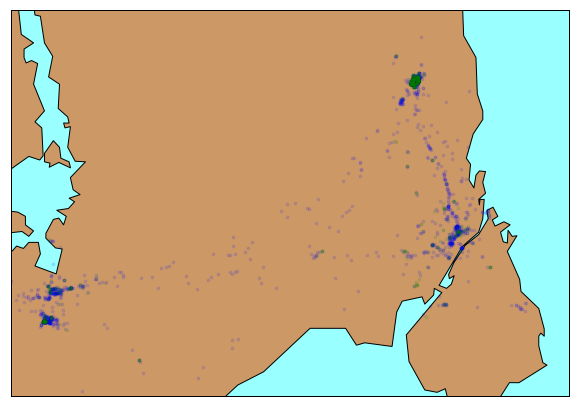

In [189]:
# Lambert Conformal Conic map.
m = Basemap(
    llcrnrlat=55.566818, llcrnrlon=12.027860, urcrnrlat=55.832270, urcrnrlon=12.709021,  # Capital region
    lat_0=53., lon_0=8.,
    projection='merc', resolution ='h',
    area_thresh=1
)

plt.figure(figsize=(10, 10))

# draw coastlines, meridians and parallels.
m.drawcoastlines()
m.drawcountries()
m.drawmapboundary(fill_color='#99ffff')
m.fillcontinents(color='#cc9966', 
                 lake_color='#99ffff')
    
x, y = m(coords[coords[:, 2] == 0, 1], coords[coords[:, 2] == 0, 0])
m.scatter(x, y, s=8, c="blue", alpha=0.1, zorder=10)
x, y = m(coords[coords[:, 2] == 1, 1], coords[coords[:, 2] == 1, 0])
m.scatter(x, y, s=8, c="green", alpha=0.1, zorder=10)

plt.show()

This seems to work! Roads are blue and lumps are green. Very nice.

Now I can **DBSCAN cluster the static points**. I'm using a small eps (in meters) because it is unlikely that points in the same clustered are more than 10 meters apart.

In [190]:
clustered_coords = coords[coords[:, 2] == 1, :]

model_DBSCAN_all_static = DBSCAN(eps=5, min_samples=2, metric=haversine_pair)
model_DBSCAN_all_static.fit(clustered_coords[:, [0, 1]])
labels = model_DBSCAN_all_static.labels_

Now I map these cluster labels back onto the original points

In [191]:
# Map medoid labels back to coordinates
coord_labels = np.ones(shape=(coords_u.shape[0], ), dtype=int) * (-1)
for gid, lab in enumerate(labels):
    coord_labels[medoid_map == gid] = lab

I'll now **visualize the most common location** to see if there are subclusters. I suspect this. If there are, the strategy is now to disregard the semidynamic points and cluster that cluster again using DBSCAN to see if we can squeeze more clusters out of it.

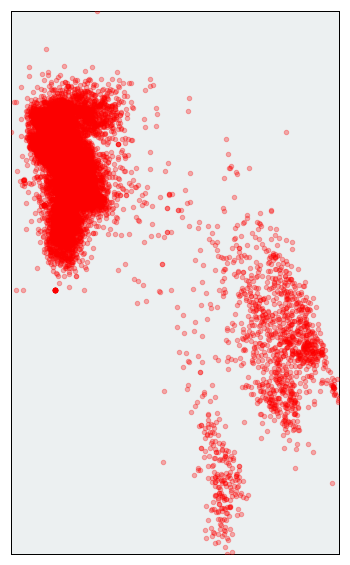

width: 42.57 m
height: 70.39 m


In [192]:
home_label = Counter(coord_labels).most_common(20)[0][0]
plot_points = coords_u[coord_labels == home_label, :]

# Get circumference of points we want to look at
maxlat = max(plot_points[:, 0]); maxlon = max(plot_points[:, 1])  # ~~*
minlat = min(plot_points[:, 0]); minlon = min(plot_points[:, 1])  # *--

plt.figure(figsize=(10, 10))

m = Basemap(
    urcrnrlat=maxlat, urcrnrlon=maxlon,  # Upper right corner (lat, lon)  ~~*
    llcrnrlat=minlat, llcrnrlon=minlon,  # Lower left  corner (lat, lon) *--
    lat_0=53., lon_0=8.,
    projection='merc', resolution ='c',
    area_thresh=1
)

# draw coastlines, meridians and parallels.
m.drawcoastlines()
m.drawcountries()
m.drawmapboundary(fill_color='#99ffff')
m.fillcontinents(color='#ecf0f1', lake_color='#99ffff')

x, y = m(plot_points[:, 1], plot_points[:, 0])
m.scatter(x, y, s=20, c="red", alpha=0.3, zorder=10)

plt.show()

width = haversine_pair(
    np.array([minlat, minlon]),
    np.array([minlat, maxlon])
)
print "width: %.02f" % width, "m"

height = haversine_pair(
    np.array([minlat, minlon]),
    np.array([maxlat, minlon])
)
print "height: %.02f" % height, "m"

If `u=0` and we're looking at the largest cluster, there should be two clear clusters. What we do now, is:
* Perform KMeans clustering for varying K (from 1 to ~5) and pick the solution that maximises some objective function. 
* What is the objective function supposed to be? Let's consider the options:
    * Clusters should have a fixed standard deviation $\sigma$ (let's choose ~3 meters).
    * The best we can assume is that the mean $\mu$ is at the center of a kernel.
    * Option 1: Model the points as a mixture of K uniform gaussians centered at each kernel.
        * Objective function is log likelihood.
    * Option 2: Model each cluster seperately. Measure log likelihood of points in each K only wrt. their corresponding gaussian.
        * Objective function is average log likelihood.
    * Likelihood has some problems. Firstly, the *number of points* available to compute the likelihood is very influential to the estimated likelihood. This doesn't matter in cases where that number of constant, but *here is it not!!!*. Therefore I think we need a measure of goodness which is independent of this quantity.

First I need a function that fits a normal distribution and measures the error.

In [210]:
K_max = 10
cov_lim = 1
scale_lim = [5, 10]
verbose = False

# The input data
X = plot_points[:, [0, 1]]
X_cart = cartesian_encoder(X)

# The extend of the input data
lat_min, lat_max = min(X[:, 0]), max(X[:, 0])
lon_min, lon_max = min(X[:, 1]), max(X[:, 1])

# The pmf bins
bins = [
    np.arange(lat_min, lat_max, meters_to_dlat(2)), # 2 m wide bins
    np.arange(lon_min, lon_max, meters_to_dlon(2, np.mean([lat_min, lat_max])))  # 2 m wide bins
]

# KMeans iteration 0
solutions = defaultdict(lambda: defaultdict(list))
for K in range(1, K_max + 1):
    
    if verbose:
        print "K:", K
        print "---" + "-" * len(str(K))
        
    # Fit the clusters
    #gmm = GaussianMixture(K, covariance_type="spherical", max_iter=20).fit(X_cart)
    #labels_ = gmm.predict(X_cart)
    labels_ = KMeans(K).fit_predict(X_cart)
    
    
    # Loop over each kernel and increment the average KS score of the partition
    for k in range(K):
        
        # Only points in kth cluster
        X_k = X[labels_ == k]

        mu_k = np.mean(X_k, axis=0)
        SD_k = np.std(X_k, axis=0)
        
        if X_k.shape[0] == 0:
            solutions[K]['kernels'].append({
                'KS_score': np.nan,
                'p': 0,
                'mu': mu_k,
                'SD': SD_k
            })
            continue
        
        # Estimate the average SD of the data in meters
        scale = np.mean([dlat_to_meters(SD_k[0]), dlon_to_meters(SD_k[1], mu_k[0])])
        
        # Clip that to fit the acceptable range
        scale = clip_range(scale, scale_lim)
        
        # Clip the SDs so they are within the scale_lim and respect the cov_lim
        SD_k = [
            clip_dlat(SD_k[0], m_lim=[scale-cov_lim, scale+cov_lim]),
            clip_dlon(SD_k[1], mu_k[0], m_lim=[scale-cov_lim, scale+cov_lim])
        ]
        
        if verbose:
            print " " * 4 + "k:", k, "    |", 
            print " " * 4 + "SD:",
            print "lat (%.03f)" % dlat_to_meters(SD_k[0]), "--",
            print "lon (%.03f)" % dlon_to_meters(SD_k[1], mu_k[0]),
            
            if scale == scale_lim[0]:
                print "... clipped to min",
            if scale == scale_lim[1]:
                print "... clipped to MAX"
            else:
                print
            
        
        # pmf and cmf of cluster. The normalization happens in a second pass
        # because the bins are in reality tiny making the height of bars enormous.
        # So when normalization just makes their summed height 1, then we implicitly
        # rescale the ranges to that each bar covers an area of 1 x 1. This simplifies
        # the way that the cmf is computed.
        pmf_k = norm_dist(np.histogram2d(X_k[:, 0], X_k[:, 1], bins=bins)[0])
        cmf_k = compute_cumulative_dist(pmf_k)
        
        # Get the "target" cmf, as the accumulate of the perfect pmf.
        pmf_t = get_normal_pmf(X_k.mean(0), bins, SD_k)
        cmf_t = compute_cumulative_dist(pmf_t)
        
        # Store solution
        solutions[K]['kernels'].append({
            'KS_score': np.max(abs(cmf_k - cmf_t)),  # max dist. between (KS score)
            'p': X_k.shape[0] * 1. / X.shape[0],     # responsibility of kth kernel
            'mu': mu_k,
            'SD': SD_k
        })
    
    # Store labels and final KS average
    solutions[K]['labels'] = labels_
    
    if verbose: print

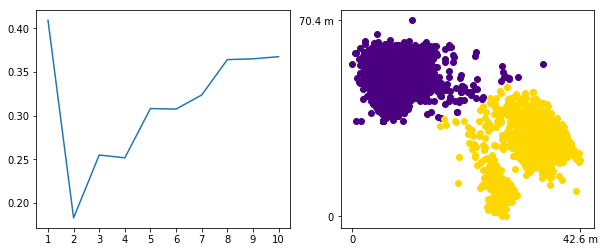

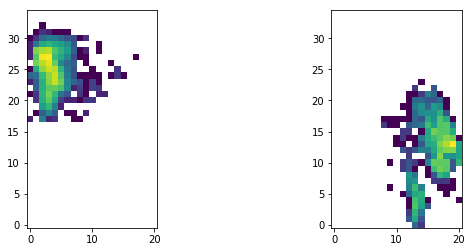

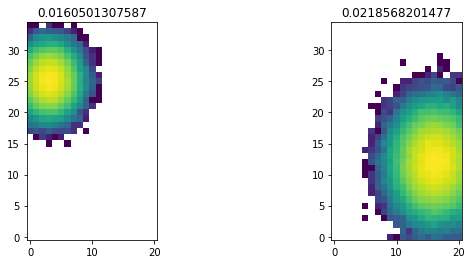

In [212]:
KS_averages = [
    np.sum([k['p'] * k['KS_score'] for k in obj['kernels']])
    for obj in solutions.values()
]
optimal_K = min_index(KS_averages) + 1
labels_ = solutions[optimal_K]['labels']

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(range(1, K_max+1), KS_averages)
plt.xticks(range(1, K_max+1))

plt.subplot(1, 2, 2)
colors = mpl.colors.CSS4_COLORS.values()
scale_lat = domain_range([min(X[:, 0]), max(X[:, 0])], [0, 100])
scale_lon = domain_range([min(X[:, 1]), max(X[:, 1])], [0, 100])
for lab in set(labels_):
    xy = X[labels_ == lab, :]
    plt.scatter(scale_lon.transform(xy[:, 1]), scale_lat.transform(xy[:, 0]), color=colors[lab], alpha=1)
plt.xticks([0, 100], [0, "%.01f m" % width])
plt.yticks([0, 100], [0, "%.01f m" % height])
    
plt.figure(figsize=(5*optimal_K, 4))
for k in range(optimal_K):
    X_k = X[labels_ == k]
    
    mu_k = solutions[optimal_K]['kernels'][k]['mu']
    SD_k = solutions[optimal_K]['kernels'][k]['SD']
    
    pmf_k = norm_dist(np.histogram2d(X_k[:, 0], X_k[:, 1], bins=bins)[0])
    cmf_k = compute_cumulative_dist(pmf_k)

    plt.subplot(1, optimal_K, k+1)
    plt.imshow(pmf_k, norm=LogNorm())
    plt.gca().invert_yaxis()
plt.show()


plt.figure(figsize=(5*optimal_K, 4))
for k in range(optimal_K):
    X_k = X[labels_ == k]
    
    mu_k = solutions[optimal_K]['kernels'][k]['mu']
    SD_k = solutions[optimal_K]['kernels'][k]['SD']
    
    pmf_k = norm_dist(np.histogram2d(X_k[:, 0], X_k[:, 1], bins=bins)[0])
    cmf_k = compute_cumulative_dist(pmf_k)

    # Get the "target" cmf, as the accumulate of the perfect pmf.
    pmf_t = get_normal_pmf(mu_k, bins, SD_k)
    cmf_t = compute_cumulative_dist(pmf_t)

    plt.subplot(1, optimal_K, k+1)
    plt.title(np.mean(abs(cmf_k - cmf_t)))
    plt.imshow(pmf_t, norm=LogNorm())
    plt.gca().invert_yaxis()
plt.show()

### General implementation

Alright! So I ended up doing the following:
1. Group temporally adjacent locations if they are close enough, hence inferring groups of stationary points.
2. Reduce each stationary group to a single points that is its median, then cluster the resulting medians with DBSCAN.
3. Expand the medians back into their constituent points, then cluster each DBSCAN cluster of points using a Gaussian Mixture Model. Settle for the number of components that minimizes the average KS statistic across clusters treated as bivariate normal distributions.
4. Map the resulting labels onto the original datapoints. -1 means non-stationary.

In [17]:
def _haversine(coord1, coord2):    
    def __to_rad(degrees):
        return degrees * 2 * np.pi / 360.

    lat1, lat2 = __to_rad(coord1[0]), __to_rad(coord2[0])
    dlat = __to_rad(coord1[0] - coord2[0])
    dlon = __to_rad(coord1[1] - coord2[1])

    a = np.sin(dlat / 2) ** 2 + \
        np.cos(lat1) * np.cos(lat2) * \
        np.sin(dlon / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a)) 

    return 6371e3 * c  # Meters
    
def group_time_distance(coords, r_C):
    """Group temporally adjacent points if they are closer than r_C.
    
    Input
    -----
        coords : array-like (shape=(N, 2))
        r_C : number (critical radius)
    
    Output
    ------
        groups : list-of-list
            Each list is a group of points
    """
    groups = []
    
    current_group = coords[0].reshape(-1, 2)
    for coord in coords[1:]:
        
        # Compute distance to current group
        dist = _haversine(np.median(current_group, axis=0), coord)
    
        # Put in current group
        if dist <= r_C:
            current_group = np.vstack([current_group, coord])
        # Or start new group if dist is too large
        else:
            groups.append(current_group)
            current_group = coord.reshape(-1, 2)

    # Add the last group
    groups.append(current_group)

    return groups

def get_stationary_medoids(groups, min_size=1):
    """Convert groups of multiple points (stationary location events) to median-of-group points.
    
    Input
    -----
        groups : list-of-list
            Each list is a group of points
        min_size : int
            Minimum size of group to consider it stationary (default: 1)
            
    Output
    ------
        stat_coords : array-like (M, 2)
            Medioids of stationary groups
    """
    stat_coords = np.empty(shape=(0, 2))
    medoid_map = []
    i = 0
    for g in groups:
        if g.shape[0] > min_size:
            stat_coords = np.vstack([stat_coords, np.median(g, axis=0).reshape(1, -1)])
            medoid_map.extend([i] * len(g)); i += 1
        else:
            medoid_map.append(-1)
            
    return stat_coords, np.array(medoid_map)

def cluster_DBSCAN(coords, eps=5, min_samples=2):
    """Get labels of DBSCAN pass over a set of coordinates.
    
    Input
    -----
        coords : array-like (N, 2)
        eps : number (max. intercluster distance)
        min_samples : int (min. cluster samples)
    
    Output
    ------
        labels : 1d array
    """
    model_DBSCAN_all_static = DBSCAN(
        eps=eps, min_samples=min_samples, metric=_haversine
    ).fit(coords)
    
    return model_DBSCAN_all_static.labels_

def optimal_sub_labeling(coords, K_max=10, var_dev=1, scale_lim=[2, 10], min_range=15, plot=False):
    """For a range of K values, return the labeling that minimizes that average KS statistic.
    
    Project points onto principle components to avoid multiple geo-problems.
    
    Input
    -----
        coords : array-like (N, 2)
        K_max : int (largest K to test)
        var_dev : number (component size deviation)
        scale_lim : list (, 2) (min-max range of cluster SD)
        min_range : number (min. range that will be clustered)
    
    Output
    ------
        out : 1d-array (point labels)
    """
    
    def _min_index(arr):
        return arr.index(min(arr))
    
    def _meters_to_dlat(m, R_E=6371e3):
        return m / R_E * 180 / np.pi

    def _dlat_to_meters(dlat, R_E=6371e3):
        return R_E * dlat * np.pi / 180

    def _meters_to_dlon(m, lat, R_E=6371e3):
        return m / R_E * 180 / np.pi / np.cos(lat * np.pi / 180)

    def _dlon_to_meters(dlon, lat, R_E=6371e3):
        return R_E * dlon * np.pi / 180 * np.cos(lat * np.pi / 180)
    
    def _clip_range(x, lim):
        return min([max([x, lim[0]]), lim[1]])
    
    def _norm_dist(p):
        return p * 1.0 / np.sum(p)

    def _compute_cumulative_dist(pmf_2d):
        cmf_2d = np.empty(shape=pmf_2d.shape)
        for i in range(pmf_2d.shape[0]):
            for j in range(pmf_2d.shape[1]):
                cmf_2d[i, j] = np.sum(pmf_2d[:i+1, :j+1])
        return cmf_2d
    
    def _cartesian_encoder(coord, r_E=6371):
        def __to_rad(deg):
            return deg * np.pi / 180.
        theta = __to_rad(coord[:, 0])  # lat [radians]
        phi = __to_rad(coord[:, 1])    # lon [radians]
        x = r_E * np.cos(phi) * np.cos(theta)
        y = r_E * np.sin(phi) * np.cos(theta)
        z = r_E * np.sin(theta)
        return np.concatenate([x.reshape(-1, 1), y.reshape(-1, 1), z.reshape(-1, 1)], axis=1)
    
    def _pca_transform(X, n_components=None):
        return PCA(n_components=n_components).fit_transform(X)
    
    def _get_normal_pmf(mu, bins, SD, size=100000):
        X = np.random.multivariate_normal(mu, np.array([[SD[0], 0], [0, SD[1]]])**2, size=size)
        return _norm_dist(np.histogram2d(X[:, 0], X[:, 1], bins=bins, normed=True)[0])

    # Adjust K_max to never exceed max possible
    K_max = min(np.unique(coords, axis=0).shape[0]-1, K_max)
    
    # Center coordinates at (0, 0)
    coords = _pca_transform(cartesian_encoder(coords, r_E=6371e3), 2)
    
    # The extend of the input data
    x_min, x_max = min(coords[:, 0]), max(coords[:, 0])
    y_min, y_max = min(coords[:, 1]), max(coords[:, 1])
    
    # Check if range is greater than min_range. If not, return single-cluster solution
    if x_max - x_min < min_range and y_max - y_min < min_range:
        return np.zeros(shape=(coords.shape[0], ), dtype=int)
    
    # The pmf bins
    bins = [
        np.arange(x_min, x_max, 2), # 2 m wide bins
        np.arange(y_min, y_max, 2)  # 2 m wide bins
    ]

    # Iteration solutions
    solutions = defaultdict(lambda: defaultdict(list))
    for K in range(1, K_max + 1):

        # Fit GMM with K components
        if K == 1:
            solutions[K]['labels'] = np.zeros(shape=coords.shape[0], dtype=int)
        else:
            solutions[K]['labels'] = KMeans(K).fit_predict(coords)

        # Loop over each kernel and increment the average KS score of the partition
        for k in range(K):
            
            # If there are no points in the k'th cluster, continue. (consider breaking)
            if not np.sum(solutions[K]['labels'] == k):
                solutions[K]['kernels'].append({'KS_score': np.nan, 'p': 0})
                continue
                
            # Only points in kth cluster
            coords_k = coords[solutions[K]['labels'] == k]
            
            # Mean and SD of that cluster
            mu_k = np.mean(coords_k, axis=0)
            SD_k = np.std(coords_k, axis=0)

            # Estimate the average SD of the data in meters
            scale = np.mean(SD_k)
            
            # Clip that to fit the acceptable range
            scale = _clip_range(scale, scale_lim)
            
            # Clip the SDs so they are within the scale_lim and respect the var_dev
            SD_k = [
                _clip_range(SD_k[0], lim=[scale-var_dev, scale+var_dev]),
                _clip_range(SD_k[1], lim=[scale-var_dev, scale+var_dev])
            ]


            # Get pmf and cmf of cluster.
            pmf_k = _norm_dist(np.histogram2d(coords_k[:, 0], coords_k[:, 1], bins=bins)[0])
            cmf_k = _compute_cumulative_dist(pmf_k)

            # Get the "target" cmf, as the accumulate of the perfect pmf.
            pmf_t = _get_normal_pmf(mu_k, bins, SD_k)
            cmf_t = _compute_cumulative_dist(pmf_t)

            # Store solution
            solutions[K]['kernels'].append({
                'KS_score': np.max(abs(cmf_k - cmf_t)),           # max dist. between (KS score)
                'p': coords_k.shape[0] * 1. / coords.shape[0]     # weight of kth kernel
            })
    
    # Compute the weighted average KS for all K
    KS_averages = [
        np.sum([k['p'] * k['KS_score'] for k in obj['kernels']])
        for obj in solutions.values()
    ]
    
    # Pick the K that yields the lowst avg. KS
    optimal_K = _min_index(KS_averages) + 1
    
    # Plot static
    if plot:
        plt.figure()
        plt.plot(range(1, K_max+1), KS_averages)
        plt.xlabel("K")
        plt.ylabel("Average KS")
        plt.show()
        
    return solutions[optimal_K]['labels']


def get_stop_location_labels(coords):
    """Get stop-location labels for time-sorted gps coordinates.
    
    Input
    -----
        coords : array-like (N, 2)
        
    Output
    ------
        out : array-like (N, )
    """
    
    def _reset_label_range(labels):
        """Reset labels to range between -1 and len(labels)."""
        unique_labels = set(labels) - {-1}
        labels_map = dict(zip(unique_labels, range(len(unique_labels))))
        labels_map[-1] = -1
        return np.array([labels_map[i] for i in labels])
    
    # 1. Get clusters of stationary points in time. Take medians
    groups = group_time_distance(coords, r_C=10)
    stat_medoids, medoid_map = get_stationary_medoids(groups, min_size=1)
    
    # 2. DBSCAN cluster the resulting stationary medoids
    labels_DBSCAN = cluster_DBSCAN(stat_medoids)
    
    # Map medoid labels back to coordinates
    coord_labels = np.ones(shape=coords.shape[0], dtype=int) * (-1)
    for gid, lab in enumerate(labels_DBSCAN):
        coord_labels[medoid_map == gid] = lab
        
    # 3. For each cluster, find subclusters with GMM
    sub_labels = np.ones(shape=coords.shape[0], dtype=int) * (-1)  # Default (-1) is outlier
    
    for lab in filter(lambda lab: lab >= 0, set(labels_DBSCAN)):  # Loop over non-outlier labels

        # Get the GMM subcluster labels
        sub_cluster_labels = optimal_sub_labeling(coords[coord_labels == lab, :], K_max=2)
        
        # Rename them so they don't conflict across clusters
        global_labels = np.array([int(str(lab)+str(sub_lab)) for sub_lab in sub_cluster_labels])

        # Store them
        sub_labels[coord_labels == lab] = global_labels

    # Rename the sublabels to a tight range
    sub_labels = _reset_label_range(sub_labels)
    
    return sub_labels

## Starness

I now want to measure how "starry" location are. A location is "starry" if short trips tend to start and end there. They are locations where we put our bag, leave to get lunch, then return to immediately after. We can also call them "keystones" of "hubs".

I measure the "starness" of a location as the fraction of trips, started at that location, that have fewer than $\tau$ other stop-locations in-between. $\tau$ should be considered a sort of *relax* parameter. The greater it is, the *easier* it is for a location to be a star, and vice versa.

### Single user experiment

#### Find star locations

First I need to label all the GPS events with stop locations. It takes about a minute for each user. Can be parallelized quite easily.

In [18]:
u = 317

# Extract user coordinates
df_u = df_locations.loc[df_locations['user'] == u]
coords_u = np.array(df_u.loc[:, ['lat', 'lon']])

# Get stop location labels for each GPS point
labels = get_stop_location_labels(coords_u)

# Stack labels onto coordinate array
coords_u = np.hstack([coords_u, labels.reshape(-1, 1)])

/opt/conda/lib/python3.6/site-packages/sklearn/decomposition/pca.py:398: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:131: RuntimeWarning: invalid value encountered in true_divide
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


In [22]:
with open("figures/Location History.json") as fp:
    data = json.load(fp)['locations']

data = sorted(data, key=lambda d: int(d[u'timestampMs']))
for d in data:
    d['timestamp'] = int(d['timestampMs']) / 1e3
    d['lat'] = d['latitudeE7'] / 1e7
    d['lon'] = d['longitudeE7'] / 1e7
    
df_ulf = pd.DataFrame(data).loc[:, ['lat', 'lon', 'timestamp']]
coords_ulf = np.array(df_ulf.loc[:, ['lat', 'lon']])

labels = get_stop_location_labels(coords_ulf)
coords_ulf = np.hstack([coords_ulf, labels.reshape(-1, 1)])

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:131: RuntimeWarning: invalid value encountered in true_divide
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


Great! Now I need to measure starness somehow. I think the fastest implementation loops over coordinates and then keeps track of started, ended and expired trips. This is really nice, because then $\tau$ directly translates to a sort of "memory" hyperparameter.

First I remove the repeated location measurements.

In [149]:
def remove_consecutive(arr):
    return np.array(
        [v for i, v in enumerate(arr) if i == 0 or v != arr[i-1]],
        dtype=int
    )

# Extract walk on labels only and remove consecutive
walk = remove_consecutive(coords_ulf[:, 2])

# Remove non-stationary steps
walk = filter(lambda step: step != -1, walk)

Now I have to device some sweet code that measures the starness of each location.

In [155]:
tau = 10
debug = False

# Store 1 for return within tau steps and 0 for not
trip_returns = defaultdict(list)

# Keep track of active trips through each step of walk
active_trips = []
for t, label in enumerate(walk):
    
    # If one of the active trips is the label, store a 1 for that
    # label and remove the match from the list of active trips
    if label in walk[max([0, t-tau]):t]:
        trip_returns[label].append(1)
        active_trips = [(label_, t_) for label_, t_ in active_trips if label_ != label]
    
    # If a trip has been active for tau steps, expire it and store
    # 0 for that label. Remove it from active trips.
    expired_trip = [(label_, t_) for label_, t_ in active_trips if t_ == t-tau]
    if len(expired_trip) == 1:
        active_trips.remove(expired_trip[0])
        trip_returns[expired_trip[0][0]].append(0)
    
    # Register the current label as an active trip
    active_trips.append((label, t))
    
    if debug:
        print "t:", t, "label:", label
        print "\tactive_trips:", active_trips
        print "\texpired_trip:", expired_trip
        raw_input()

# Compute stats for the 0s and 1s. Mean is 'starness'.
starness = dict(
    (k, {'mean': np.mean(v), 'std': np.std(v), 'count': len(v)})
    for k, v in trip_returns.items()
)

Seems like it works. Let's plot some of the stats.

First I wan't to see what the distribution of starness looks like for different 'count' thresholds. **Are popular locations more 'starry'?**

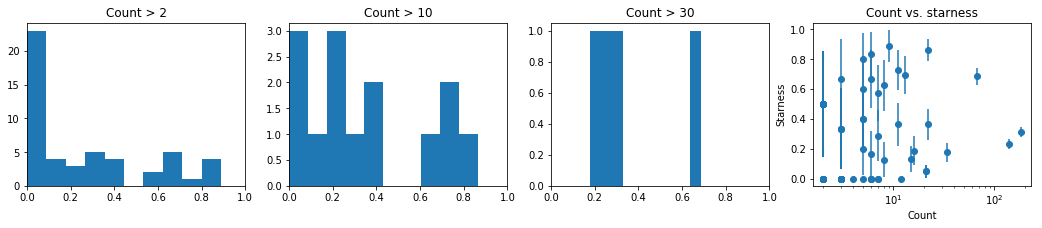

In [152]:
# Tau = 1
plt.figure(figsize=(18, 3))

for i, c in enumerate([2, 10, 30], 1):
    plt.subplot(1, 4, i)
    plt.title("Count > %d" % c)
    plt.hist([v['mean'] for v in starness.values() if v['count'] > c])
    plt.xlim(0, 1)

plt.subplot(1, 4, 4)
plt.title("Count vs. starness")
plt.errorbar(
    x=[v['count'] for v in starness.values()],
    y=[v['mean'] for v in starness.values()],
    yerr=[v['std']/np.sqrt(v['count']) for v in starness.values()],
    fmt="o"
)
plt.xlabel("Count")
plt.ylabel("Starness")
plt.xscale("log")

plt.show()

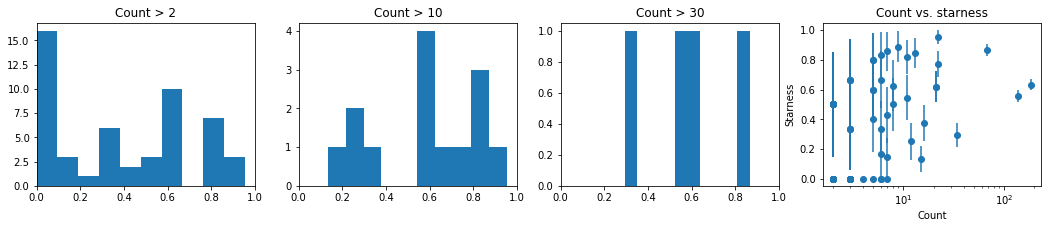

In [154]:
# Tau = 2
plt.figure(figsize=(18, 3))

for i, c in enumerate([2, 10, 30], 1):
    plt.subplot(1, 4, i)
    plt.title("Count > %d" % c)
    plt.hist([v['mean'] for v in starness.values() if v['count'] > c])
    plt.xlim(0, 1)

plt.subplot(1, 4, 4)
plt.title("Count vs. starness")
plt.errorbar(
    x=[v['count'] for v in starness.values()],
    y=[v['mean'] for v in starness.values()],
    yerr=[v['std']/np.sqrt(v['count']) for v in starness.values()],
    fmt="o"
)
plt.xlabel("Count")
plt.ylabel("Starness")
plt.xscale("log")

plt.show()

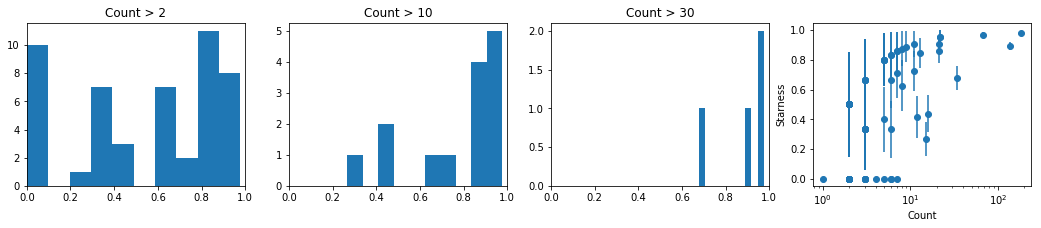

In [157]:
# Tau = 10
plt.figure(figsize=(18, 3))

for i, c in enumerate([2, 10, 30], 1):
    plt.subplot(1, 4, i)
    plt.title("Count > %d" % c)
    plt.hist([v['mean'] for v in starness.values() if v['count'] > c])
    plt.xlim(0, 1)

plt.subplot(1, 4, 4)
plt.errorbar(
    x=[v['count'] for v in starness.values()],
    y=[v['mean'] for v in starness.values()],
    yerr=[v['std']/np.sqrt(v['count']) for v in starness.values()],
    fmt="o"
)    
plt.xlabel("Count")
plt.ylabel("Starness")
plt.xscale("log")

plt.show()

Like suspected, a higher $\tau$ gives more starry locations. The correlation between popularity and starriness increases with $\tau$, which makes sense, because an increase in $\tau$ is greater relative to their interevent-times.

I want to see what these locations look like. I plot a point for each location, the size of which corresponds to the starness.

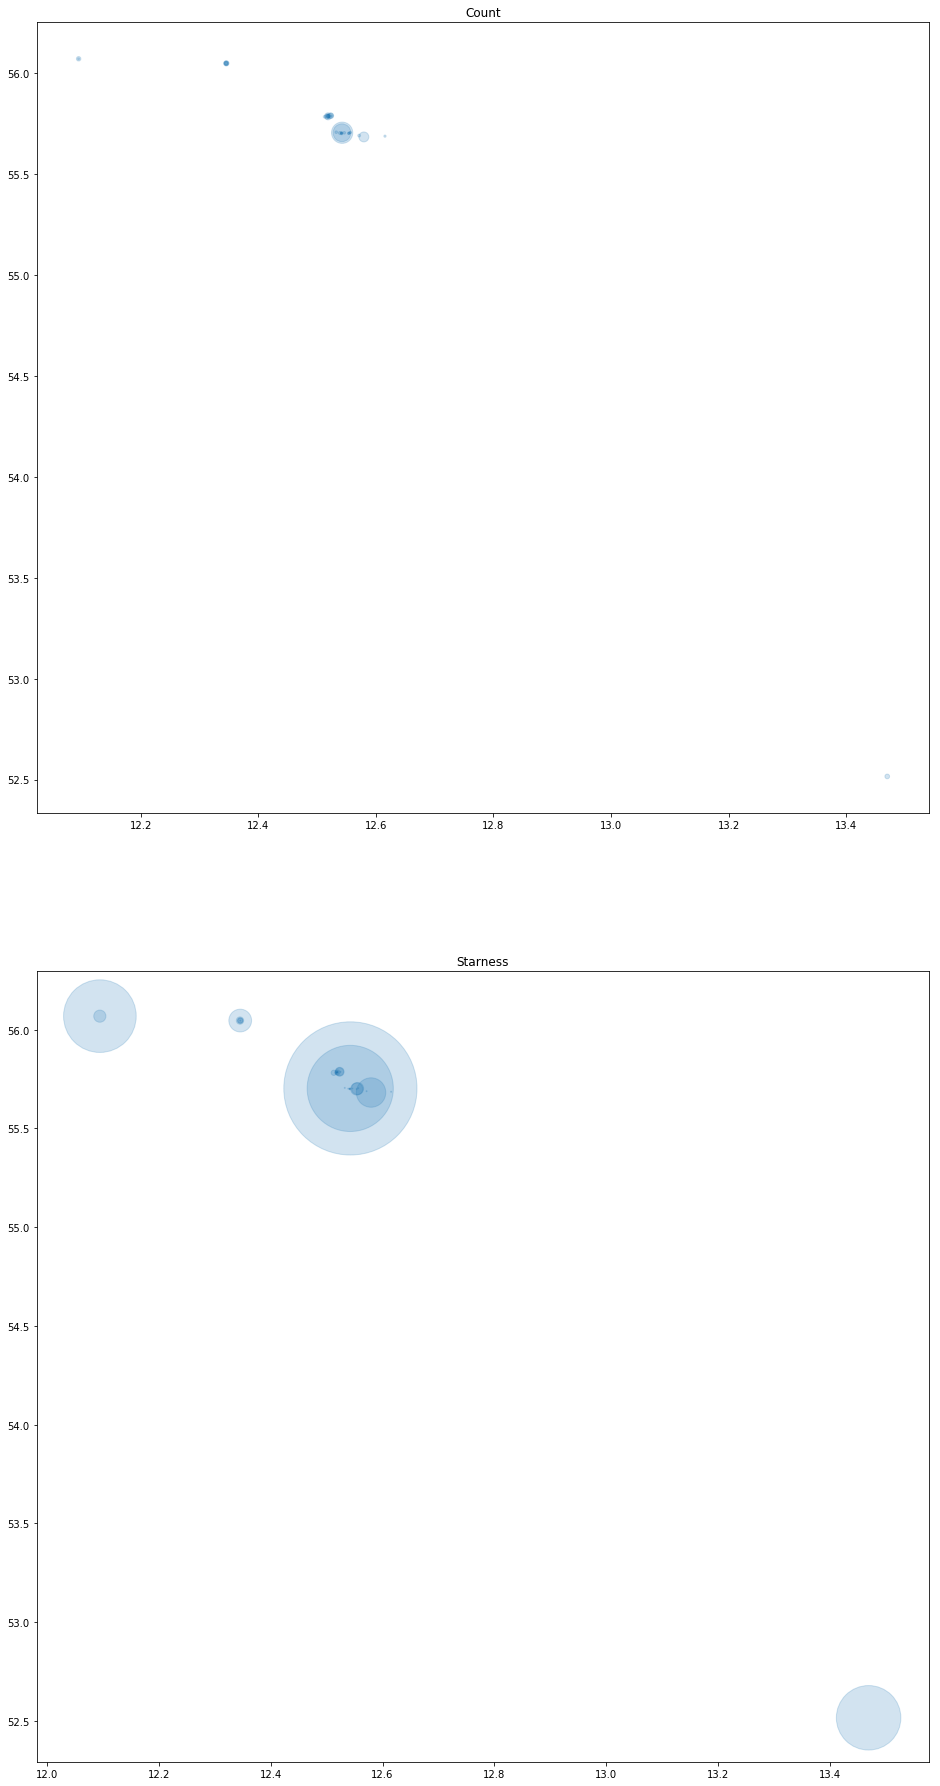

In [158]:
lat, lon, c, s = [], [], [], []
for label, stats in trip_returns.iteritems():
    coords_cluster = coords_ulf[coords_ulf[:, 2] == label, :2]
    coords_cluster_mean = coords_cluster.mean(0)
    
    if (50 < coords_cluster_mean[0] < 60) and (11 < coords_cluster_mean[1] < 14):
        lat.append(coords_cluster_mean[0])
        lon.append(coords_cluster_mean[1])
        c.append(coords_cluster.shape[0])
        s.append(np.exp(np.mean(stats)*10))
    
plt.figure(figsize=(16, 16*2))
plt.subplot(2, 1, 1)
plt.title("Count")
plt.scatter(lon, lat, s=c, alpha=0.2)
plt.subplot(2, 1, 2)
plt.title("Starness")
plt.scatter(lon, lat, s=s, alpha=0.2)
plt.show()

So cool! Locations seem to fit inside each other. Especially so with the "count" as size parameter, which is not what I expected. There, locations nest inside of each other in a fashion where there is one large (likely "keystone" location) and a bunch of small ones. For starness there are many large inside of each other.

Maybe we should plot the locations differently: not as points with size corresponding to some metric, but rather as convex hulls of their most visited locations that are within $\tau$.

#### Convex hull within $\tau$

The idea here, is that we can visualize locations as the convex hull of the locations they visit within $\tau$ steps. Star locations would then be visualized as a large polygon, while non-star locations would converge to single points.

The function below explains the algorithm, but the main idea is basically just to record the neighborhoods of locations and the points that are visited on trips shorted than $\tau$ that start and end at a given location. While measuring that we can also measure starness and location count.

In [159]:
def get_location_neighborhood(coords_u, tau):
    """Compute starness and neighborhood hull for all points in a labeled walk.
    
    Algorithm:
        1. Loop over locations, while recording the latest tau locations,
        2. If current location was visited within tau steps (not timesteps),
        record all intermediate steps as part of the neighborhood.
    
    Input
    -----
        coords_u : 2darray (N, 3)
            Coordinates in a walk. 3rd column is the label of location in the walk.
        tau : int (0 < tau)
            Maximal time-steps allowed away from home to count visited locations as neighborhood
    
    Output
    ------
        location_stats : nested dictionaries. Supports:
            location_stats[label]['count']
            location_stats[label]['starness']
            location_stats[label]['neighborhood']         
    """
    # Record neighborhood locations for each location
    location_stats = defaultdict(lambda: defaultdict(list))

    active_locations = []
    for t, (lat, lon, label) in enumerate(coords_u):

        # Location changed
        if t > 0 and label != coords_u[t-1, 2]:

            # Location is visited recently (update star area)
            if label in [label_ for t_, label_ in active_locations]:

                # Get timestamp of last visit
                t_ = active_locations[get_last_index([label_ for t_, label_ in active_locations], label)][0]

                # Get all points visited between last visit and now
                trailing_coords = coords_u[t_:t, :]
                location_stats[label]['neighborhood'].extend(trailing_coords.tolist())
                location_stats[label]['trip_returns'].append(1)
            
            if label != -1:
                location_stats[label]['count'].append(1)

        # If location is stationary add to active_locations
        if label != -1:
            active_locations.append((t, label))

        # Remove expired active locations
        active_locations = [(t_, label_) for t_, label_ in active_locations if t_ > t - tau]

    # Tidy results
    for label, data in location_stats.items():

        if data['neighborhood'] == []:
            data['neighborhood'] = coords_u[coords_u[:, 2] == label]

        # Compute count, starness and neighborhood hull
        data['count'] = sum(data['count'])
        data['starness'] = sum(data['trip_returns']) * 1. / data['count']
        data['neighborhood'] = get_hull(np.array(data['neighborhood'])[:, :2])

        # Remove binary record of trip returns
        del data['trip_returns']
        
    return location_stats

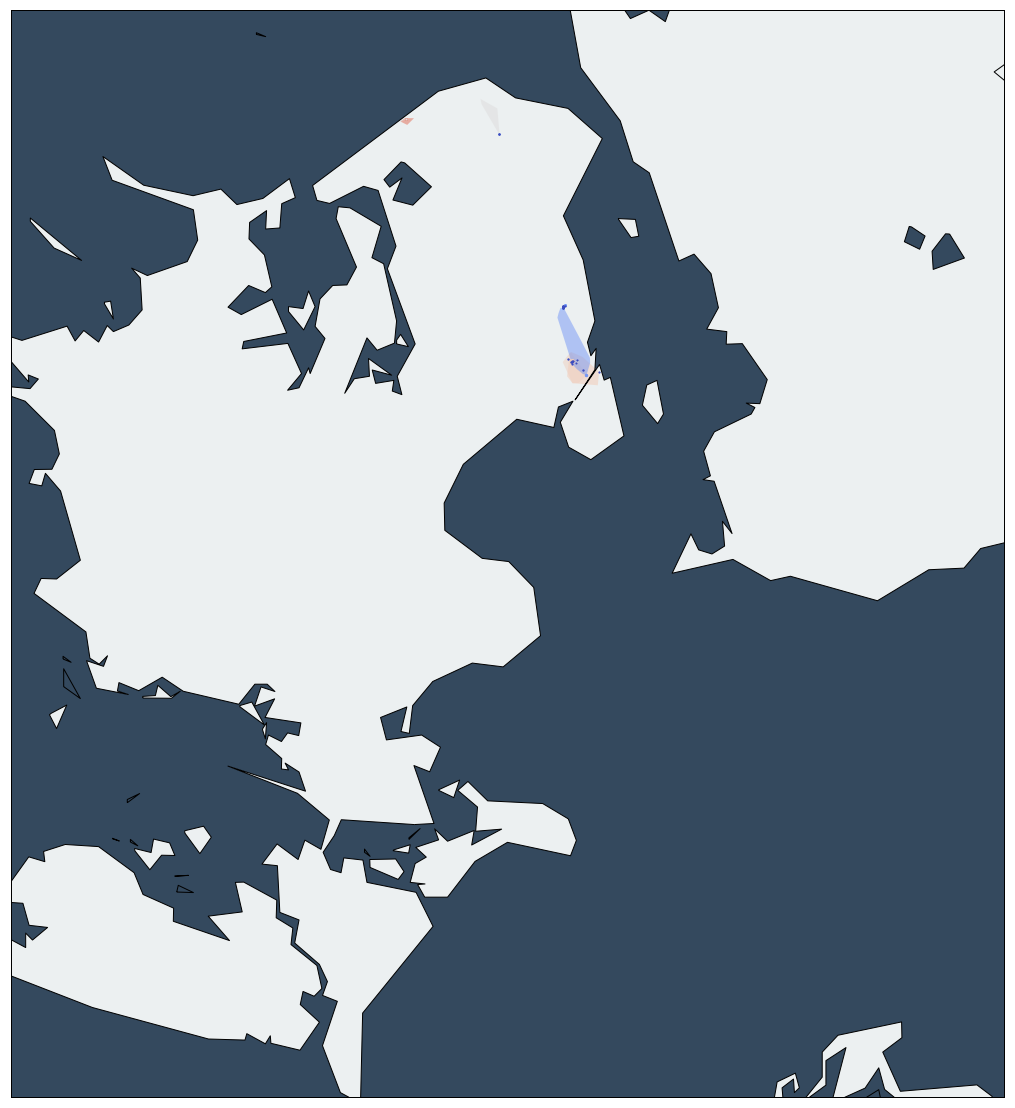

In [166]:
# Compute the neighborhoods
location_stats = get_location_neighborhood(coords_ulf, tau=25)

cmap = cmap_in_range([0, 1], cmap_style="coolwarm")

plt.figure(figsize=(20, 20))

# Basemap
m = Basemap(
    llcrnrlat=54.566818, llcrnrlon=11.027860, urcrnrlat=56.232270, urcrnrlon=13.709021,  # Capital region
    lat_0=53., lon_0=8.,
    projection='merc', resolution ='i',
    area_thresh=1
)

# Coastlines, meridians and parallels.
m.drawcoastlines()
m.drawcountries()
m.drawmapboundary(fill_color='#34495e')
m.fillcontinents(color='#ecf0f1', lake_color='#34495e')

# Sort neigborhoods by starness (only for visualization)
starness_sorted_location_stats = sorted(
    location_stats.items(),
    key=lambda (label_, _): location_stats[label_]['starness'],
    reverse=True
)

hull_areas = dict()
for label, data in starness_sorted_location_stats:
    
#     if label == -1:
#         continue
    
    neighborhood = data['neighborhood'].points[data['neighborhood'].vertices]
    
    draw_map_poly(
        neighborhood[:, 0], neighborhood[:, 1],
        m, cmap(data['starness'])
    )
    x, y = m(*np.mean(coords_ulf[coords_ulf[:, 2] == label, :2][:, ::-1], axis=0))
    plt.scatter(x, y, marker="o", c=cmap(data['starness']), s=np.sqrt(data['count']), zorder=100)
    
    hull_areas[label] = data['neighborhood'].area
    
plt.savefig("figures/hulls.pdf")
plt.show()

There is not as much correlation between neighborhood size (hull area) and starness as I was expecting. This probably has something to do with the timescale $\tau$ being fixed. Let's try to measure the return times for different locations.

#### Return time distributions

Here I simply measure the time it takes for trips leaving some location, to return. For context I also record at what times the location is most frequently entered, exited and stayed at.

In [168]:
# Record neighborhood locations for each location
event_times = defaultdict(lambda: defaultdict(list))

for t, (lat, lon, label) in enumerate(coords_ulf):

    # Location changed
    if t > 0 and label != coords_ulf[t-1, 2]:
        
        # Record exit-time (if prev. loc. was static)
        if coords_ulf[t-1, 2] != -1:
            event_datetime = dt.fromtimestamp(df_u.iloc[t-1].timestamp)
            event_times[coords_ulf[t-1, 2]]['exit'].append(event_datetime.hour + event_datetime.minute * 1. / 60)

        # Record enter-time (if curr. loc. is static)
        if label != -1:
            event_datetime = dt.fromtimestamp(df_u.iloc[t].timestamp)
            event_times[label]['enter'].append(event_datetime.hour + event_datetime.minute * 1. / 60)

        # Record return time (if curr. loc is static and seen before)
        if label != -1 and label in coords_ulf[:t, 2]:
            t_ = get_last_index(coords_ulf[:t, 2], label)
            event_times[label]['return'].append(t - t_)
    
    # Record stay-time (if curr. loc. is static)
    if label != -1:
        event_datetime = dt.fromtimestamp(df_u.iloc[t].timestamp)
        event_times[label]['stay'].append(event_datetime.hour + event_datetime.minute * 1. / 60)


Lets plot some of those distributions:

In [169]:
sorted_event_times = sorted(event_times.items(), key=lambda (label_, data_): len(data_['stay']), reverse=True)

location: [ 55.70265229  12.54251057]


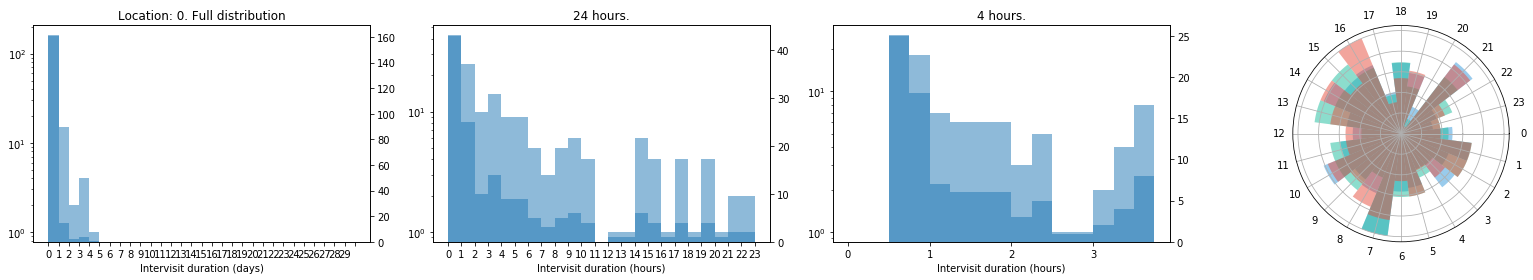

location: [ 55.70258279  12.54221366]


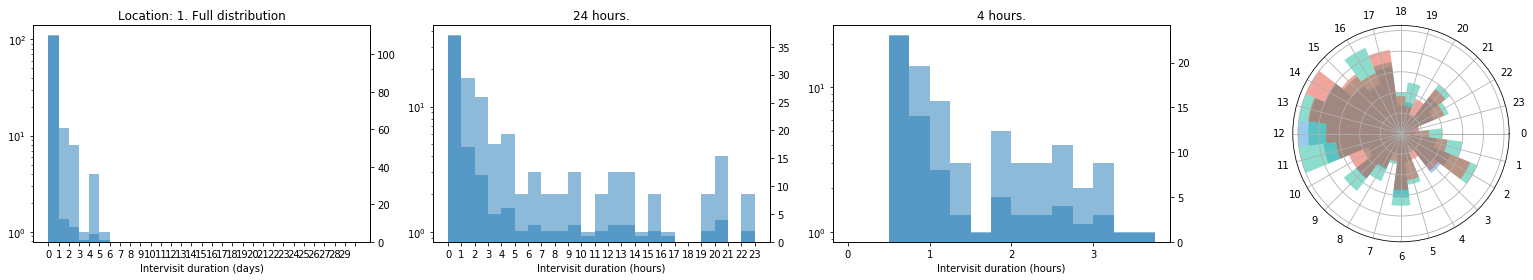

location: [ 32.09468232  34.79045307]


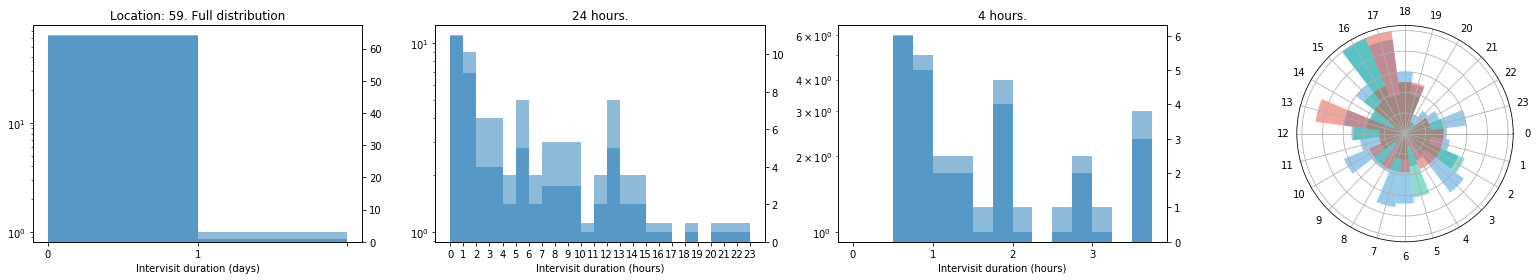

location: [ 64.1230794  -21.85639073]


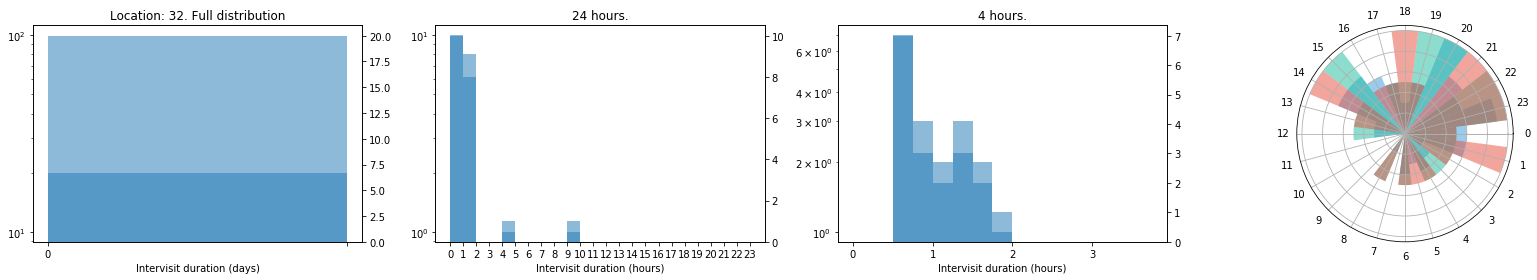

location: [ 55.68185426  12.57946384]


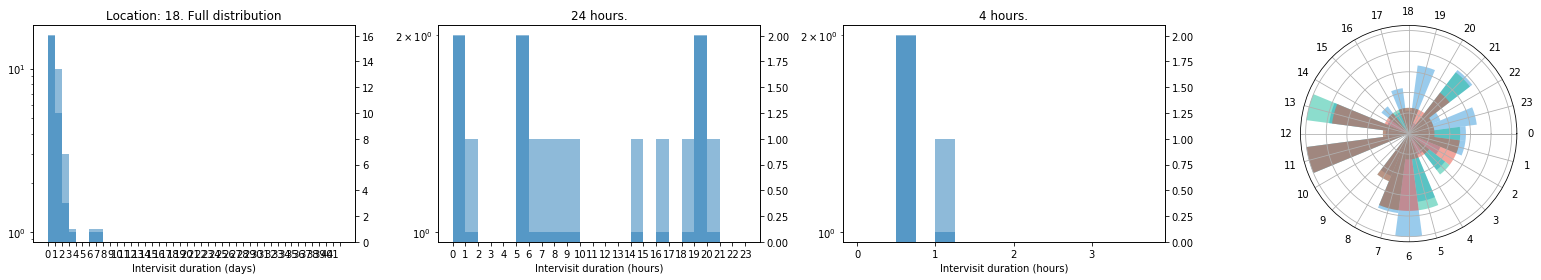

In [181]:
for label, data in sorted_event_times[:5]:
    
    print "location:", np.mean(coords_ulf[coords_ulf[:, 2] == label, :2], axis=0)
    
    fig, ax = plt.subplots(1, 4, figsize=(22, 4))
    
    ax[0].set_title("Location: %d. Full distribution" % label)
    ax[0].hist(data['return'], bins=range(0, max(data['return']), 96), alpha=0.5)
    ax[0].set_xticks(range(0, max(data['return']), 96))
    ax[0].set_xticklabels(range(0, max(data['return'])/96))
    ax[0].set_xlabel("Intervisit duration (days)")
    ax[0].set_yscale("log")
    ax0copy = ax[0].twinx()
    ax0copy.hist(data['return'], bins=range(0, max(data['return']), 96), alpha=0.5)

    ax[1].set_title("24 hours." % label)
    ax[1].hist(filter(lambda t: t < 96, data['return']), bins=range(0, 96, 4), alpha=0.5)
    ax[1].set_xticks(range(0, 96, 4))
    ax[1].set_xticklabels(range(0, 24))
    ax[1].set_xlabel("Intervisit duration (hours)")
    ax[1].set_yscale("log")
    ax1copy = ax[1].twinx()
    ax1copy.hist(filter(lambda t: t < 96, data['return']), bins=range(0, 96, 4), alpha=0.5)

    ax[2].set_title("4 hours." % label)
    ax[2].hist(filter(lambda t: t < 16, data['return']), bins=range(0, 16, 1), alpha=0.5)
    ax[2].set_xticks(range(0, 16, 4))
    ax[2].set_xticklabels(range(0, 4))
    ax[2].set_xlabel("Intervisit duration (hours)")
    ax[2].set_yscale("log")
    ax2copy = ax[2].twinx()
    ax2copy.hist(filter(lambda t: t < 16, data['return']), bins=range(0, 16, 1), alpha=0.5)
    
    ax[3] = plt.subplot(1, 4, 4, polar=True)
    plt_circular_timedist(data['stay'], color="#3498db", ax=ax[3])   # Blue
    plt_circular_timedist(data['enter'], color="#1abc9c", ax=ax[3])  # Green
    plt_circular_timedist(data['exit'], color="#e74c3c", ax=ax[3])   # Red 
    
    plt.tight_layout()
    plt.show()

<bound method AxesSubplot.properties of <matplotlib.axes._subplots.AxesSubplot object at 0x7f90739cfa50>>

# Junkyard

In [161]:
class GaussianMixtureFixedCov:
    
    def __init__(self, n_components, cov, max_iter=100, random_state=None, tol=1e-8):
        self.n_components = n_components
        self.cov = cov
        self.max_iter = max_iter
        self.random_state = random_state
        self.tol = tol
        
    def fit(self, X):
        
        self.n_obs, self.n_features = X.shape
        
        # 1: Initialize
        self.mu = X[np.random.choice(self.n_obs, size=self.n_components)]
        self.pi = np.ones(shape=self.n_components) / float(self.n_components)
        
        for i in range(self.max_iter):
            
            # 1: E-step
            resp = self.predict_proba(X)

            # 2. M-step
            new_mu = self._update_mu(X, resp)
            new_pi = self._update_pi(X, resp)
            
            # Evaluate stopping criteria
            if np.sum(np.abs(new_mu-self.mu)) < self.tol:
                break
            else:
                self.mu = new_mu
                self.pi = new_pi
            
        self.n_iter_ = i
        #self.llik = self._eval_loglik(X)
    
    
    def _eval_loglik(self, X):
        return np.sum(
            np.log(
                np.sum(
                    [self.pi[k] * multivariate_normal.pdf(X, mean=self.mu[k], cov=self.cov) for k in range(self.n_components)],
                    axis=0)))
    
    def _update_mu(self, X, resp):
        return np.array([
            1. / np.sum(resp[:, k]) * np.sum(resp[:, k].reshape(self.n_obs, 1) * X, axis=0)
            for k in range(self.n_components)
        ])
    
    def _update_pi(self, X, resp):
        return np.array([
            np.sum(resp[:, k]) / self.n_obs
            for k in range(self.n_components)
        ])
    
    def predict_proba(self, X):
        likelihood = np.hstack([
            self.pi[k] * multivariate_normal.pdf(X, mean=self.mu[k], cov=self.cov).reshape(self.n_obs, 1)
            for k in range(self.n_components)
        ])
        
        resp = np.hstack([
            (likelihood[:, k] / likelihood.sum(1)).reshape(self.n_obs, 1)
            for k in range(self.n_components)
        ])

        return resp
    
    def predict(self, X):
        if X.shape != (self.n_obs, self.n_features):
            raise ValueError("Shape of array must be (%d, %d)." % (self.n_obs, self.n_features))
        return np.argmax(self.predict_proba(X), axis=1)
    
            
model2 = GaussianMixtureFixedCov(n_comps, cov)
model2.fit(X)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

class FixedCovMixture:
    """ The model to estimate gaussian mixture with fixed covariance matrix. """
    def __init__(self, n_components, cov, max_iter=100, random_state=None, tol=1e-10):
        self.n_components = n_components
        self.cov = cov
        self.random_state = random_state
        self.max_iter = max_iter
        self.tol=tol

    def fit(self, X):
        # initialize the process:
        np.random.seed(self.random_state)
        n_obs, n_features = X.shape
        self.mean_ = X[np.random.choice(n_obs, size=self.n_components)]
        # make EM loop until convergence
        for i in range(self.max_iter):
            new_centers = self.updated_centers(X)
            if np.sum(np.abs(new_centers-self.mean_)) < self.tol:
                break
            else:
                self.mean_ = new_centers
        self.n_iter_ = i

    def updated_centers(self, X):
        """ A single iteration """
        # E-step: estimate probability of each cluster given cluster centers
        cluster_posterior = self.predict_proba(X)
        # M-step: update cluster centers as weighted average of observations
        weights = (cluster_posterior.T / cluster_posterior.sum(axis=1)).T
        new_centers = np.dot(weights, X)
        return new_centers


    def predict_proba(self, X):
        likelihood = np.stack([
            multivariate_normal.pdf(X, mean=center, cov=self.cov) 
            for center in self.mean_
        ])
        cluster_posterior = (likelihood / likelihood.sum(axis=0))
        return cluster_posterior

    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=0)

In [171]:
model2 = GaussianMixtureFixedCov(n_comps, cov)
model2.fit(X)
print model2.n_iter_

89


In [172]:
model1 = FixedCovMixture(n_comps, cov)
model1.fit(X)
print model1.n_iter_

99


(2, 100)


ValueError: operands could not be broadcast together with shapes (2,1) (100,3) 

In [19]:
X.shape

(100, 3)

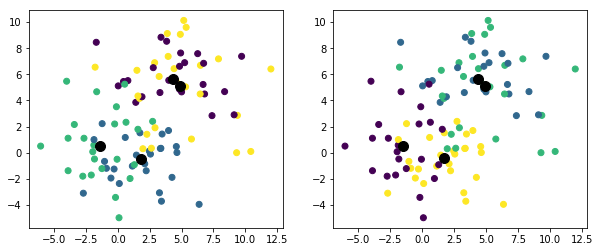

In [179]:
X = np.random.normal(size=(100,3), scale=3)
X[50:] += (5, 5, -5)

cov = [[3, 0, 0], [0, 3, 0], [0, 0, 3]]
n_comps = 4

# Model 1
model1 = FixedCovMixture(n_comps, cov)
model1.fit(X)

# Model 2
model2 = GaussianMixtureFixedCov(n_comps, cov)
model2.fit(X)

# Plot
dim_a, dim_b = 0, 1

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.scatter(X[:, dim_a], X[:, dim_b], c=model1.predict(X))
plt.scatter(model1.mean_[:, dim_a], model1.mean_[:, dim_b], s=100, c='k')

plt.subplot(1, 2, 2)
plt.scatter(X[:, dim_a], X[:, dim_b], c=model2.predict(X))
plt.scatter(model2.mu[:, dim_a], model2.mu[:, dim_b], s=100, c='k')

plt.show()

In [1543]:
# make some data
X = np.random.normal(size=(100,2), scale=3)
X[50:] += (10, 5)

# Hyperparameters
n_components = 2
cov = [[10, 0], [0, 10]]

# Dimensionality
n_obs, n_features = X.shape

# 1. Initialize means
mu_ = X[np.random.choice(n_obs, size=n_components)]
cov_ = cov
pi_ = [0.5, 0.5]

# 2. E step
resp = eval_resp(X, mu_, cov_, pi_)

# 3. M 
mu_new = []
pred = np.argmax(resp, axis=1)
for k in range(n_components):
    1. / np.sum(pred == k) * np.sum([])

In [66]:
model2.predict(X)

array([ 1, 50])

In [181]:
sum(model2.pi)

1.0

In [1537]:
def predict_proba(X, mu, cov, pi):
    piN = np.empty(shape=(n_obs, 0))
    for k in range(n_components):
        piN = np.hstack([piN, pi[k] * multivariate_normal.pdf(X, mean=mu[k], cov=cov).reshape(-1, 1)])

    resp = np.empty(shape=(n_obs, 0))
    for k in range(n_components):
        resp = np.hstack([resp, (piN[:, k] / piN.sum(1)).reshape(-1, 1)])
        
    return resp

In [1551]:
np.sum([[1] * len(multivariate_normal.pdf(X, mean=mu_[k], cov=cov_)) for k in range(n_components)], axis=0)

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2])

In [1500]:
resp

[array([ 0.9999218 ,  0.94652473,  0.9985291 ,  0.99994263,  0.99893173,
         0.99996418,  0.99999088,  0.9989923 ,  0.99994824,  0.99956896,
         0.99985866,  0.99964822,  0.99993962,  0.99902397,  0.98756843,
         0.99993734,  0.98392126,  0.99999599,  0.99964728,  0.9997734 ,
         0.99944703,  0.97717439,  0.99757555,  0.99966075,  0.99998368,
         0.99994601,  0.99997819,  0.99983202,  0.99956277,  0.9998679 ,
         0.94766331,  0.9996156 ,  0.99981224,  0.99939036,  0.99871147,
         0.99981521,  0.99998778,  0.99946157,  0.99994675,  0.99974478,
         0.99999982,  0.99999247,  0.99999846,  0.99995291,  0.99993916,
         0.99831194,  0.99996482,  0.99473609,  0.99504564,  0.9899744 ,
         0.6224727 ,  0.01326574,  0.19113044,  0.7678903 ,  0.04754539,
         0.00348865,  0.71014984,  0.62114431,  0.1229686 ,  0.00130912,
         0.65854714,  0.79805211,  0.00608531,  0.04702153,  0.02375566,
         0.00169841,  0.57053456,  0.15967875,  0.0

In [1489]:
from scipy.stats import multivariate_normal
multivariate_normal

In [ ]:
tau = 3
debug = True

# Store 1 for return within tau steps and 0 for not
location_neighborhoods = defaultdict(list)

# Keep track of active trips through each step of walk
tau_steps = []
for t, (lat, lon, label) in enumerate(coords_u):
    
    if (t > 0 and label == coords_u[t-1, 2]):
        continue
    
    # If the label is within the last tau steps, add all coordinates
    # between now and then (not including dynamic points)
    if label in [label_ for label_, t_ in tau_steps]:
        last_index = get_last_index(coords_u[:t, 2], label)
        star_walk = coords_u[last_index:t, :]
        #star_walk = star_walk[star_walk[:, 2] != -1, :]  # Remove dynamic points
        location_neighborhoods[label].extend(star_walk.tolist())
    
    # Expire oldest location from memory
    if label != -1:
        tau_steps.append((label, t))
    tau_steps = [(label_, t_) for label_, t_ in tau_steps if t_ > t - tau]
    
    if debug:
        print "t:", t, "label:", label
        print "\ttau_steps:", tau_steps
        print "\tlen(location_neighborhoods[label]):", len(location_neighborhoods[label])
        raw_input()
        
    

In [ ]:
def draw_screen_poly(lats, lons, m):
    x, y = lons, lats#m(lons, lats)
    poly = Polygon(zip(x,y), facecolor='#3498db', alpha=0.4)
    plt.gca().add_patch(poly)

# Lambert Conformal Conic map.
# m = Basemap(
#     llcrnrlat=54.566818, llcrnrlon=11.027860, urcrnrlat=56.232270, urcrnrlon=13.709021,  # Capital region
#     lat_0=53., lon_0=8.,
#     projection='merc', resolution ='c',
#     area_thresh=1
# )

plt.figure(figsize=(20, 20))

# draw coastlines, meridians and parallels.
# m.drawcoastlines()
# m.drawcountries()
# m.drawmapboundary(fill_color='#34495e')
# m.fillcontinents(color='#ecf0f1', lake_color='#34495e')

# Draw polygons
for i, points in enumerate(location_neighborhoods.values()):
    points = np.array(points)[:, :2]
    try:
        hull = ConvexHull(points)
    except scipy.spatial.qhull.QhullError:
        continue
    polygon = points[hull.vertices, :]
    draw_screen_poly(polygon[:, 0], polygon[:, 1], m)
    plt.scatter(*np.mean(points[:, ::-1], axis=0), marker="*", c="#f1c40f")
    
    #print hull.area
    
plt.xlim(12.25, 12.7)
plt.ylim(55.5, 56.0)

plt.show()

In [ ]:
def plot_hull(points):
    points = np.array(points)[: ,:2]
    hull = ConvexHull(points[:, :2])
    polygon = points[hull.vertices, :]
    
points_hull = np.array(location_neighborhoods)
hull = ConvexHull(points_hull[:, :2])
polygon = points_hull[hull.vertices, :2]

plt.figure()
poly = Polygon(polygon, facecolor='#3498db', alpha=0.4)
plt.gca().add_patch(poly)
# plot_convex_hull(points_hull[:, :2])
# plot_convex_hull(polygon)
plt.xlim(10, 14)
plt.ylim(50, 60)
plt.show()

In [ ]:
def plot_convex_hull(points):
    hull = ConvexHull(points)
    plt.plot(points[:,0], points[:,1], 'o')
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1], 'k-')
    plt.plot(points[hull.vertices,0], points[hull.vertices,1], 'r--', lw=2)
    plt.plot(points[hull.vertices[0],0], points[hull.vertices[0],1], 'ro')

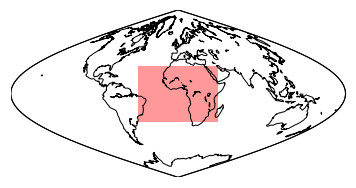

In [770]:
from mpl_toolkits.basemap import Basemap
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

def draw_screen_poly(lats, lons, m):
    x, y = m(lons, lats)
    xy = zip(x,y)
    poly = Polygon( xy, facecolor='red', alpha=0.4 )
    plt.gca().add_patch(poly)

lats = [ -30, 30, 30, -30 ]
lons = [ -50, -50, 50, 50 ]

m = Basemap(projection='sinu',lon_0=0)
m.drawcoastlines()
m.drawmapboundary()
draw_screen_poly( lats, lons, m )

plt.show()

In [562]:
def max_loglik_kmeans(X, SD=3e-5):
    """Return labels for X datapoints in max loglik KMeans solution.
    
    Using the knowledge that each cluster is supposed to have a
    certain standard deviation and zero covariances, we can find
    the optimal number of K in a Kmeans clustering scheme as that
    which maximizes the likelihood of a mixture of uniform gaussians.
    
    Input
    -----
        X : np.array (X.shape == (N, 2))
        SD : float
        
    Output
    ------
        labels : np.array (labels.shape = (N, ))
    """
    def _random_X(mu, size, SD=SD):
        return np.random.multivariate_normal(mu, np.array([[SD, 0], [0, SD]])**2, size=size)

    def _twodim_normal(X, mu, SD=SD):
        return 1. / (2 * np.pi * SD**2) * \
               np.exp(-1. / (2 * SD**2) * ((X[:, 0] - mu[0])**2 + (X[:, 1] - mu[1])**2))
    
    # The extend of the input data
    xmin, xmax = min(X[:, 0]), max(X[:, 0])
    ymin, ymax = min(X[:, 1]), max(X[:, 1])

    # The pmf bins
    xbins = np.arange(xmin, xmax, 0.00002)  # 2.22 m wide bins
    ybins = np.arange(ymin, ymax, 0.00002)  # 2.22 m wide bins

    loglik = []
    for K in range(1, 6):

        # Cluster with K components
        kmeans = KMeans(K).fit(X)

        loglik_K = 0
        for k in range(K):
            gamma = np.sum(kmeans.labels_ == k) * 1. / X.shape[0]
            likelihood = twodim_normal(X, kmeans.cluster_centers_[k, :])
            loglik_K += gamma * np.log(likelihood)

        loglik.append(loglik_K)
    
    optimal_K = loglik.index(max(loglik))
    kmeans_labels = KMeans(optimal_K).fit_predict(X)
    

In [ ]:
home_label = Counter(model.labels_).most_common(10)[0][0]
points = static_coords[(model.labels_ == home_label) | (), :]

plt.figure(figsize=(10, 10))

m = Basemap(
    #llcrnrlat=55.5, llcrnrlon=12,
    #llcrnrlat=55.566818, llcrnrlon=12.027860, urcrnrlat=55.832270, urcrnrlon=12.709021,  # Capital region
    #llcrnrlat=55.621028, llcrnrlon=12.185015, urcrnrlat=55.623156, urcrnrlon=12.189122,  # Likely home location  # of user I cant find
    llcrnrlat=min(points[:, 0]), llcrnrlon=min(points[:, 1]), urcrnrlat=max(points[:, 0]), urcrnrlon=max(points[:, 1]),  # Likely home location
    #llcrnrlat=55.788956, llcrnrlon=12.524551, urcrnrlat=55.789854, urcrnrlon=12.527425,  # Building 116
    lat_0=53., lon_0=8.,
    projection='merc', resolution ='c',
    area_thresh=1
)

# draw coastlines, meridians and parallels.
m.drawcoastlines()
m.drawcountries()
m.drawmapboundary(fill_color='#99ffff')
m.fillcontinents(color='#ecf0f1', lake_color='#99ffff')

cmap = cmap_in_categories(set(model.labels_))
for label in set(model.labels_):
    label_points = static_coords[model.labels_ == label]
    x, y = m(label_points[:, 1], label_points[:, 0])
    color = cmap(label) if label != -1 else (0, 0, 0, 1)
    m.scatter(x, y, s=20, c=color, alpha=1 if label != 1 else 1, zorder=10)

plt.xticks()
plt.show()

In [171]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

range_n_clusters = range(2, 6)

def silhouette_clustering(X, range_n_cluster=range(1, 6), method=KMeans, *model_params):
    xmin, xmax = min(X[:, 0]), max(X[:, 0])
    ymin, ymax = min(X[:, 1]), max(X[:, 1])
    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
        
        # Set x and y lim for second plot
        ax2.set_xlim([xmin-(xmax-xmin)*0.1, xmax+(xmax-xmin)*0.1])
        ax2.set_ylim([ymin-(ymax-ymin)*0.1, ymax+(ymax-ymin)*0.1])

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        clusterer = method(n_clusters, *model_params)
        cluster_labels = clusterer.fit_predict(X)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(X, cluster_labels)
        print("For n_clusters =", n_clusters,
              "The average silhouette_score is :", silhouette_avg)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        colors = cm.spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                    c=colors, edgecolor='k')

        # Labeling the clusters
        centers = clusterer.cluster_centers_
        # Draw white circles at cluster centers
        ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                    c="white", alpha=1, s=200, edgecolor='k')

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                        s=50, edgecolor='k')

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                      "with n_clusters = %d" % n_clusters),
                     fontsize=14, fontweight='bold')

        plt.show()

('For n_clusters =', 2, 'The average silhouette_score is :', 0.48427875642263041)


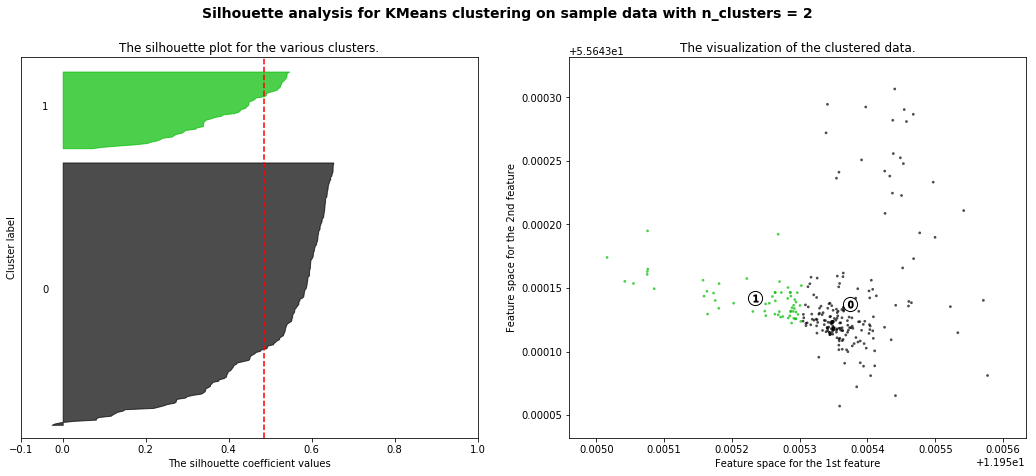

('For n_clusters =', 3, 'The average silhouette_score is :', 0.61135509627144458)


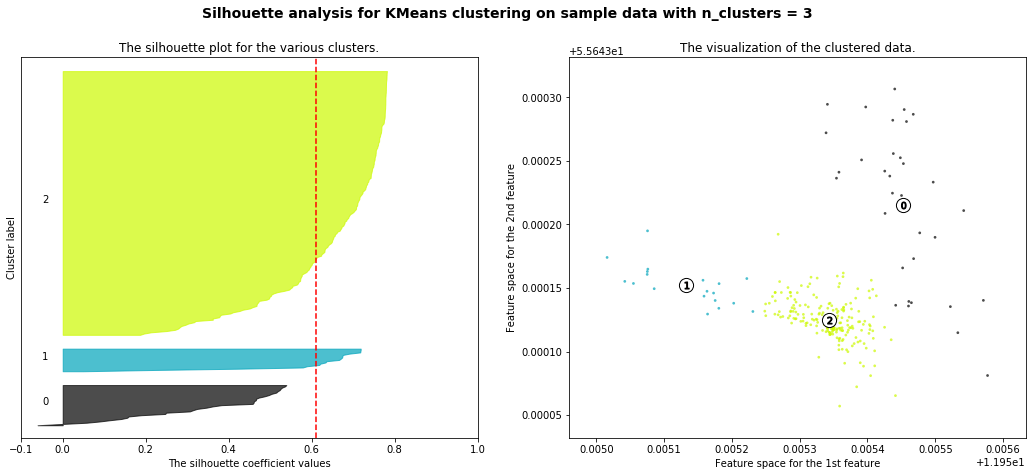

('For n_clusters =', 4, 'The average silhouette_score is :', 0.50503976818607255)


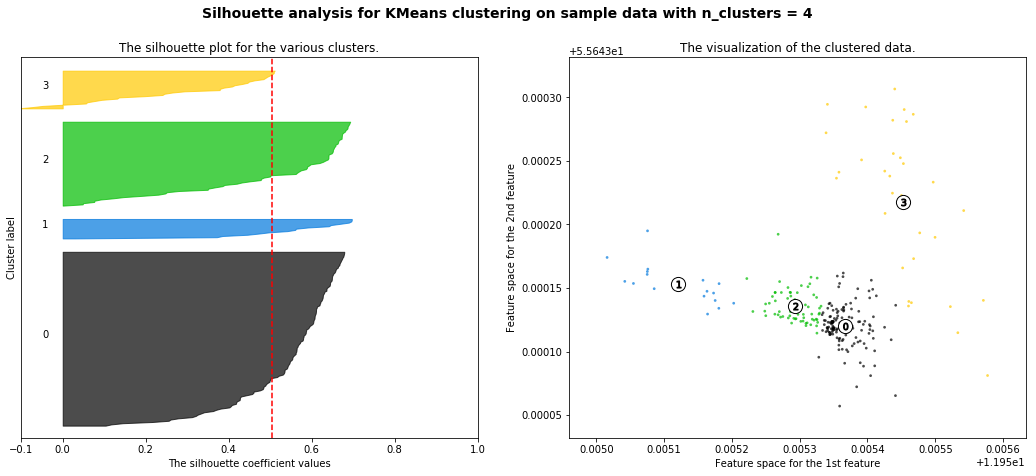

('For n_clusters =', 5, 'The average silhouette_score is :', 0.53095430293087154)


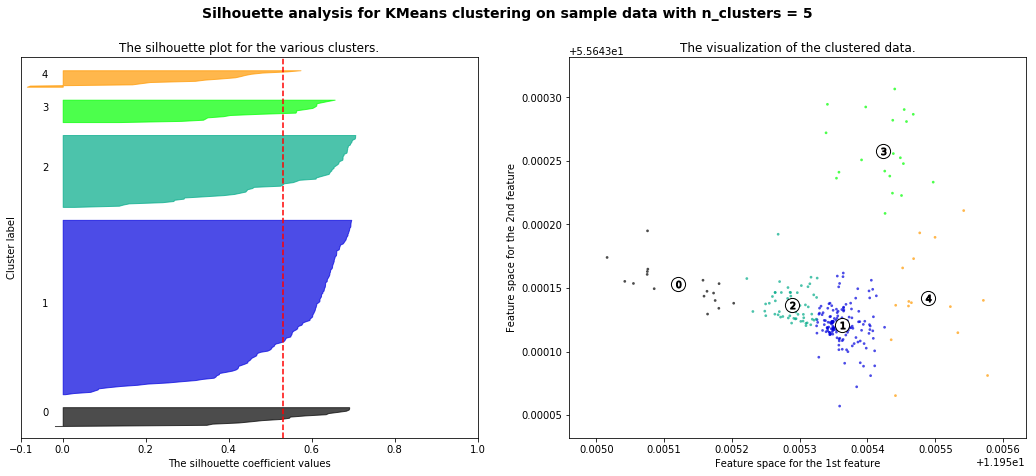

In [173]:
silhouette_clustering(plot_points[:, [1, 0]])

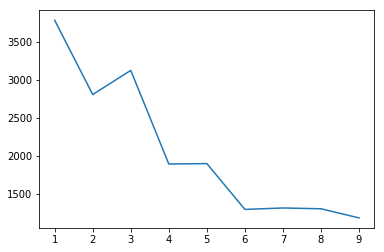

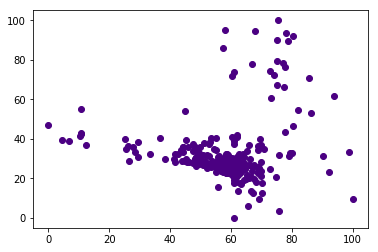

In [108]:
X = plot_points[:, [0, 1]]

K_max = 10

loglik = []
#loglik_r = []
for K in range(1, K_max):

    # Cluster with K components
    kmeans = KMeans(K).fit(X)
    mu = kmeans.cluster_centers_

    summed_log_likelihood = 0
    #summed_log_likelihood_r = 0
    for k in range(K):
        pi_k = np.sum(kmeans.labels_ == k) * 1. / X.shape[0]
        X_k = X[kmeans.labels_ == k, :]
        #X_r = random_X(X_k.mean(0), size=X_k.shape[0])
        summed_log_likelihood += pi_k * np.sum(np.log(N(X_k, mu[k])))
        #summed_log_likelihood_r += np.sum(np.log(N(X_r, mu[k])))
        

    loglik.append(summed_log_likelihood)
    #loglik_r.append(summed_log_likelihood_r)

optimal_K = loglik.index(max(loglik)) + 1
kmeans_labels = KMeans(optimal_K).fit_predict(X)

plt.plot(range(1, K_max), loglik)
plt.xticks(range(1, K_max))
plt.show()

colors = mpl.colors.CSS4_COLORS.values()
scale_lat = domain_range([min(X[:, 0]), max(X[:, 0])], [0, 100])
scale_lon = domain_range([min(X[:, 1]), max(X[:, 1])], [0, 100])
for lab in set(kmeans_labels):
    xy = X[kmeans_labels == lab, :]
    plt.scatter(scale_lon.transform(xy[:, 1]), scale_lat.transform(xy[:, 0]), color=colors[lab], alpha=1)
    

In [583]:
# The extend of the input data
xmin, xmax = min(X[:, 0]), max(X[:, 0])
ymin, ymax = min(X[:, 1]), max(X[:, 1])

# The pmf bins
xbins = np.arange(xmin, xmax, 0.00002)  # 2.22 m wide bins
ybins = np.arange(ymin, ymax, 0.00002)  # 2.22 m wide bins

loglik, loglik_alt = [], []
for K in range(1, 6):

    # Cluster with K components
    kmeans = KMeans(K).fit(X)

    X_alt = np.vstack([
        random_X(kmeans.cluster_centers_[k, :], size=np.sum(kmeans.labels_ == k))
        for k in range(K)
    ])

    loglik_K, loglik_alt_K = 0, 0
    for k in range(K):

        # Get responsibility of k'th cluster
        gamma = np.sum(kmeans.labels_ == k) * 1. / X.shape[0]

        # Compute likelihood of points in k'th cluster
        loglik_K += gamma * np.log(np.sum(twodim_normal(X, kmeans.cluster_centers_[k, :])))
        #loglik_alt_K += gamma * np.log(np.sum(twodim_normal(X_alt, kmeans.cluster_centers_[k, :])))

        # Plotting
        if K == None:
            X_k = X[kmeans.labels_ == k]
            X_r = random_X(X_k.mean(0), size=X_k.shape[0])

            plt.figure(figsize=(10, 4))
            plt.subplot(1, 2, 1)
            plt.title(loglik[-1])
            pmf_k = norm_dist(np.histogram2d(X_k[:, 0], X_k[:, 1], bins=[xbins, ybins], normed=True)[0])
            plt.imshow(pmf_k[::-1, :])
            plt.subplot(1, 2, 2)
            plt.title(loglik_bound[-1])
            pmf_bound = norm_dist(np.histogram2d(X_r[:, 0], X_r[:, 1], bins=[xbins, ybins], normed=True)[0])
            plt.imshow(pmf_bound[::-1, :])
            plt.show()

    loglik.append(loglik_K)
    loglik_alt.append(loglik_alt_K)
    
loglik

[(19.50553219906514, 25.037362823454192),
 (23.743550778717676, 24.427083469355889),
 (23.573714464775765, 24.157708580492667),
 (23.543108305457537, 24.100260171559178),
 (23.445495797752098, 23.75238004955353)]

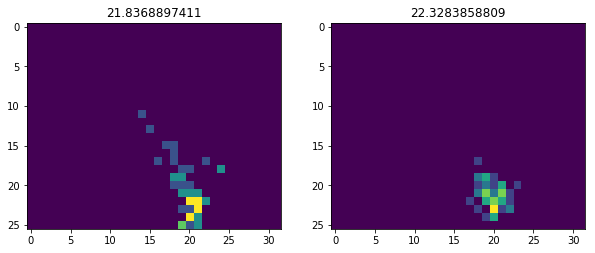

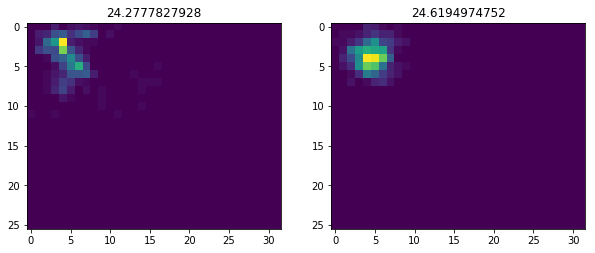

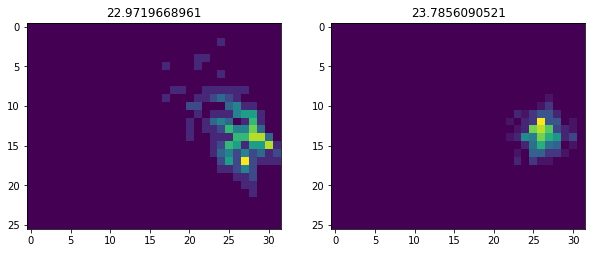

In [521]:
# The input data
X = plot_points[:, [0, 1]]

# The extend of the input data
xmin, xmax = min(X[:, 0]), max(X[:, 0])
ymin, ymax = min(X[:, 1]), max(X[:, 1])

# The pmf bins
xbins = np.arange(xmin, xmax, 0.00002)  # 2.22 m wide bins
ybins = np.arange(ymin, ymax, 0.00002)  # 2.22 m wide bins

# Print the bin width
# haversine_pair(
#     [xbins[0], ybins[0]],
#     [xbins[1], ybins[0]],
# )


# KMeans iteration 0
loglik_mean, loglik_bound_mean = [], []
for K in range(1, 6):
    
    # Cluster with K components
    kmeans_labels = KMeans(K).fit_predict(X)
    
    loglik, loglik_bound = [], []
    for k in range(K):
        
        # Get points in k'th cluster
        X_k = X[kmeans_labels == k]
        
        # Create random cluster to compare with (for measuring bound)
        X_r = random_X(X_k.mean(0), size=X_k.shape[0])
        
        # Compute likelihood of points in k'th cluster
        log_likelihood = np.log(np.sum(twodim_normal(X_k, X_k.mean(0))))
        loglik.append(log_likelihood)
        
        # Compute likelihood of points in 
        log_likelihood_bound = np.log(np.sum(twodim_normal(X_r, X_r.mean(0))))
        loglik_bound.append(log_likelihood_bound)
    
        if K == 3:
            plt.figure(figsize=(10, 4))
            plt.subplot(1, 2, 1)
            plt.title(loglik[-1])
            pmf_k = norm_dist(np.histogram2d(X_k[:, 0], X_k[:, 1], bins=[xbins, ybins], normed=True)[0])
            plt.imshow(pmf_k[::-1, :])
            plt.subplot(1, 2, 2)
            plt.title(loglik_bound[-1])
            pmf_bound = norm_dist(np.histogram2d(X_r[:, 0], X_r[:, 1], bins=[xbins, ybins], normed=True)[0])
            plt.imshow(pmf_bound[::-1, :])
            plt.show()

    
    loglik_mean.append(np.mean(loglik))
    loglik_bound_mean.append(np.mean(loglik_bound))

In [ ]:
# The input data
X = plot_points[:, [0, 1]]

# The extend of the input data
xmin, xmax = min(X[:, 0]), max(X[:, 0])
ymin, ymax = min(X[:, 1]), max(X[:, 1])

# The pmf bins
xbins = np.arange(xmin, xmax, 0.00002)  # 2.22 m wide bins
ybins = np.arange(ymin, ymax, 0.00002)  # 2.22 m wide bins

# Print the bin width
# haversine_pair(
#     [xbins[0], ybins[0]],
#     [xbins[1], ybins[0]],
# )


# KMeans iteration 0
error_mean, error_bound_mean = [], []
for K in range(1, 6):
    error, error_bound = [], []
    kmeans_labels = KMeans(K).fit_predict(X)
    for label in range(K):
        X_k = X[kmeans_labels == label]
        pmf_k = np.histogram2d(
            X_k[:, 0], X_k[:, 1], bins=[xbins, ybins], normed=True
        )[0]

        pmf_k = norm_dist(pmf_k)
        pmf_target = get_normal_pmf(X_k.mean(0))
        pmf_bound = get_normal_pmf(X_k.mean(0), size=X_k.shape[0])

        error.append(np.mean(abs(pmf_k - pmf_target)))
        error_bound.append(np.mean(abs(pmf_target - pmf_bound)))
    
#         if K == 3:
#             plt.figure(figsize=(8, 4))
#             plt.subplot(1, 2, 1)
#             plt.title(error[-1])
#             plt.imshow(pmf_k)
#             plt.subplot(1, 2, 2)
#             plt.title(error_bound[-1])
#             plt.imshow(pmf_bound)
#             plt.show()

    
    error_mean.append(np.mean(error))
    error_bound_mean.append(np.mean(error_bound))

In [107]:
scale_lat = domain_range([min(home_points[:, 0]), max(home_points[:, 0])], [0, 100])
scale_lon = domain_range([min(home_points[:, 1]), max(home_points[:, 1])], [0, 100])
X = np.hstack([scale_lon.transform(home_points[:, 1]).reshape(-1, 1), scale_lat.transform(home_points[:, 0]).reshape(-1, 1)])
X_unique = np.unique(X, axis=0)

colors = mpl.colors.CSS4_COLORS.values()
n_components = 4
scale_lat = domain_range([min(home_points[:, 0]), max(home_points[:, 0])], [0, 100])
scale_lon = domain_range([min(home_points[:, 1]), max(home_points[:, 1])], [0, 100])
X = np.hstack([scale_lon.transform(home_points[:, 1]).reshape(-1, 1), scale_lat.transform(home_points[:, 0]).reshape(-1, 1)])
X_unique = np.unique(X, axis=0)

def make_ellipses(gmm, ax):
    for n, color in enumerate(colors[:n_components]):
        if gmm.covariance_type == 'full':
            covariances = gmm.covariances_[n][:2, :2]
        elif gmm.covariance_type == 'tied':
            covariances = gmm.covariances_[:2, :2]
        elif gmm.covariance_type == 'diag':
            covariances = np.diag(gmm.covariances_[n][:2])
        elif gmm.covariance_type == 'spherical':
            covariances = np.eye(gmm.means_.shape[1]) * gmm.covariances_[n]
        v, w = np.linalg.eigh(covariances)
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        ell = mpl.patches.Ellipse(gmm.means_[n, :2], v[0], v[1],
                                  180 + angle, color=color)
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)

# Try GMMs using different types of covariances.
estimator = GaussianMixture(
    n_components=n_components, covariance_type="spherical", max_iter=20, random_state=0
)

fig = plt.figure(figsize=(10, 10))

# Initiate kernels in random points
estimator.means_init = np.array([
    X_unique[np.random.randint(0, X_unique.shape[0]), :]
    for i in range(n_components)
])

# Train the other parameters using the EM algorithm.
estimator.fit(X)

# Plot ellipses
h = plt.subplot(1, 1, 1)
make_ellipses(estimator, h)

y = estimator.predict(X)

# Plot the test data with crosses
for n, color in enumerate(colors):
    plt.scatter(X[y==n, 0], X[y==n, 1], marker='o', alpha=0.5, color=color)

if index % 2 == 1:
    plt.yticks(())
if index < 2:
    plt.xticks(())
plt.title(name)

plt.legend(scatterpoints=1, loc='lower right', prop=dict(size=12))
plt.title("Log-likelihood: %0.4f" % estimator.lower_bound_)
plt.show()

NameError: name 'home_points' is not defined

In [199]:
import sys
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn import metrics

from spherecluster import SphericalKMeans
from spherecluster import VonMisesFisherMixture
from spherecluster import sample_vMF

plt.ion()


def r_input(val=None):
    val = val or ''
    if sys.version_info[0] >= 3:
        return eval(input(val))

    return raw_input(val)


###############################################################################
# Generate small-mix dataset
mu_0 = np.array([-0.251, -0.968, -0.105])
mu_0 = mu_0 / np.linalg.norm(mu_0)
mu_1 = np.array([0.399, 0.917, 0.713])
mu_1 = mu_1 / np.linalg.norm(mu_1)
mus = [mu_0, mu_1]
kappa_0 = 8  # concentration parameter
kappa_1 = 2  # concentration parameter
kappas = [kappa_0, kappa_1]
num_points_per_class = 300

X_0 = sample_vMF(mu_0, kappa_0, num_points_per_class)
X_1 = sample_vMF(mu_1, kappa_1, num_points_per_class)
X = np.zeros((2 * num_points_per_class, 3))
X[:num_points_per_class, :] = X_0
X[num_points_per_class:, :] = X_1
labels = np.zeros((2 * num_points_per_class, ))
labels[num_points_per_class:] = 1

In [201]:
###############################################################################
# Mixture of von Mises Fisher clustering (soft)
vmf_soft = VonMisesFisherMixture(n_clusters=2, posterior_type='soft', n_init=20)
vmf_soft.fit(X_cart)

cdists = []
for center in vmf_soft.cluster_centers_:
    cdists.append(np.linalg.norm(mus[0] - center))

vmf_soft_mu_0_idx = np.argmin(cdists)
vmf_soft_mu_1_idx = 1 - vmf_soft_mu_0_idx

vmf_soft_mu_0_error = np.linalg.norm(
        mus[0] - vmf_soft.cluster_centers_[vmf_soft_mu_0_idx])
vmf_soft_mu_1_error = np.linalg.norm(
        mus[1] - vmf_soft.cluster_centers_[vmf_soft_mu_1_idx])

ValueError: VMF scaling denominator was inf.

In [ ]:
###############################################################################
# Mixture of von Mises Fisher clustering (hard)
vmf_hard = VonMisesFisherMixture(n_clusters=2, posterior_type='hard', n_init=20)
vmf_hard.fit(X)

cdists = []
for center in vmf_hard.cluster_centers_:
    cdists.append(np.linalg.norm(mus[0] - center))

vmf_hard_mu_0_idx = np.argmin(cdists)
vmf_hard_mu_1_idx = 1 - vmf_hard_mu_0_idx

vmf_hard_mu_0_error = np.linalg.norm(
        mus[0] - vmf_hard.cluster_centers_[vmf_hard_mu_0_idx])
vmf_hard_mu_1_error = np.linalg.norm(
        mus[1] - vmf_hard.cluster_centers_[vmf_hard_mu_1_idx])


In [298]:
loader.docs('bluetooth')

IOError: File /opt/conda/envs/python2/lib/python2.7/site-packages/sensible_raw/documentation_files/bluetooth.csv does not exist

In [293]:
?GaussianMixture